# Localized Entropy Notebook

This notebook runs the end-to-end pipeline using the config in `configs/default.json`.
Switch between synthetic and CTR data, tune the model, and toggle plots from the config file.


In [1]:
"""Set up imports, config, output capture, and device/seed."""
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from localized_entropy.config import (
    load_and_resolve,
    loss_label,
    get_condition_label,
    get_data_source,
    resolve_loss_modes,
)
from localized_entropy.utils import init_device, set_seed
from localized_entropy.data.pipeline import prepare_data
from localized_entropy.training import evaluate, predict_probs
from localized_entropy.analysis import (
    print_pred_summary,
    print_pred_stats_by_condition,
    collect_le_stats_per_condition,
    collect_logits,
    bce_log_loss,
    roc_auc_score,
    pr_auc_score,
    expected_calibration_error,
    binary_classification_metrics,
    per_condition_metrics,
    per_condition_mean,
    per_condition_calibration,
    per_condition_calibration_from_base_rates,
    summarize_per_ad_train_eval_rates,
)
from localized_entropy.plotting import (
    plot_training_distributions,
    plot_eval_log10p_hist,
    plot_loss_curves,
    plot_eval_predictions_by_condition,
    plot_calibration_ratio_by_condition,
    plot_pred_to_train_rate,
    plot_le_stats_per_condition,
    plot_grad_sq_sums_by_condition,
    plot_ctr_filter_stats,
    plot_feature_distributions_by_condition,
    plot_label_rates_by_condition,
    build_eval_epoch_plotter,
    build_eval_batch_plotter,
)
from localized_entropy.experiments import (
    resolve_eval_bundle,
    resolve_train_eval_bundle,
    build_loss_loaders,
    select_eval_loader,
    build_model,
    train_single_loss,
    build_seed_sequence,
    run_repeated_loss_experiments,
)
from localized_entropy.compare import (
    compare_bce_le_runs,
    summarize_model_metrics,
    format_comparison_table,
    format_bce_le_summary,
    build_repeat_metrics_frame,
    summarize_repeat_metrics,
    build_wilcoxon_summary,
    format_wilcoxon_summary,
    build_per_condition_calibration_wilcoxon,
    sort_per_condition_wilcoxon_frame,
)
from localized_entropy.outputs import build_output_paths, start_notebook_output_capture
np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4)
# Load config and resolve experiment overrides
CONFIG_PATH = "configs/default.json"
cfg = load_and_resolve(CONFIG_PATH)
train_cfg = cfg["training"]
loss_modes = resolve_loss_modes(train_cfg.get("loss_mode", "localized_entropy"))
if not loss_modes:
    raise ValueError(f"Unsupported loss_mode: {train_cfg.get('loss_mode')}")
# Start output capture for each loss mode
output_paths = {loss_mode: build_output_paths(cfg, loss_mode) for loss_mode in loss_modes}
if "notebook_output_capture" in globals():
    if hasattr(notebook_output_capture, "stop"):
        notebook_output_capture.stop()
notebook_output_capture = start_notebook_output_capture(output_paths)
print(f"Using experiment: {cfg['experiment'].get('name', cfg['experiment'].get('active', 'unknown'))}")
# Initialize device and RNG seeds
device_cfg = cfg.get("device", {})
use_mps_flag = bool(device_cfg.get("use_mps", True))
deterministic_flag = bool(device_cfg.get("deterministic", False))
device, use_cuda, use_mps, non_blocking = init_device(use_mps=use_mps_flag, deterministic=deterministic_flag)
cpu_float64 = device.type == "cpu" and not use_mps_flag
model_dtype = torch.float64 if cpu_float64 else torch.float32
set_seed(cfg['project']['seed'], use_cuda, deterministic=deterministic_flag)


Using experiment: default_net
Using CUDA device: NVIDIA GeForce RTX 5090


[WARN] Uniform log10 sampling clipped probabilities for 3/4 conditions. Consider adjusting uniform_log10_means or uniform_log10_std.
Staging datasets directly on CUDA for batch sampling.
Training loss modes: bce, localized_entropy, focal
[INFO] Using true per-condition base rates for LE denominator (synthetic).
Evaluation split: Eval
TensorBatchLoader on CUDA (batches per epoch: 432 / 48). | deterministic shuffle enabled (seed=42, cpu_perm=True)


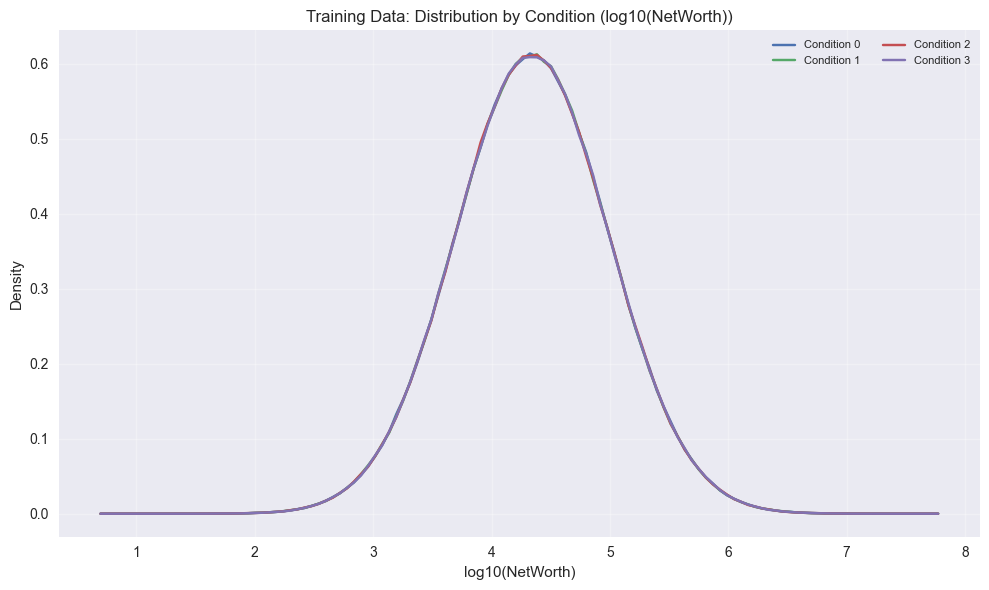

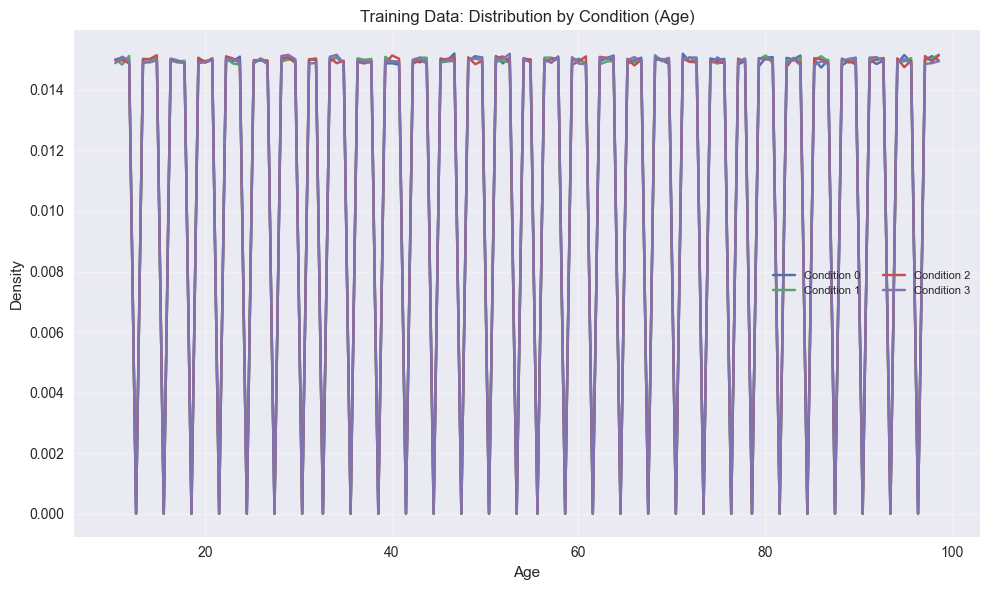

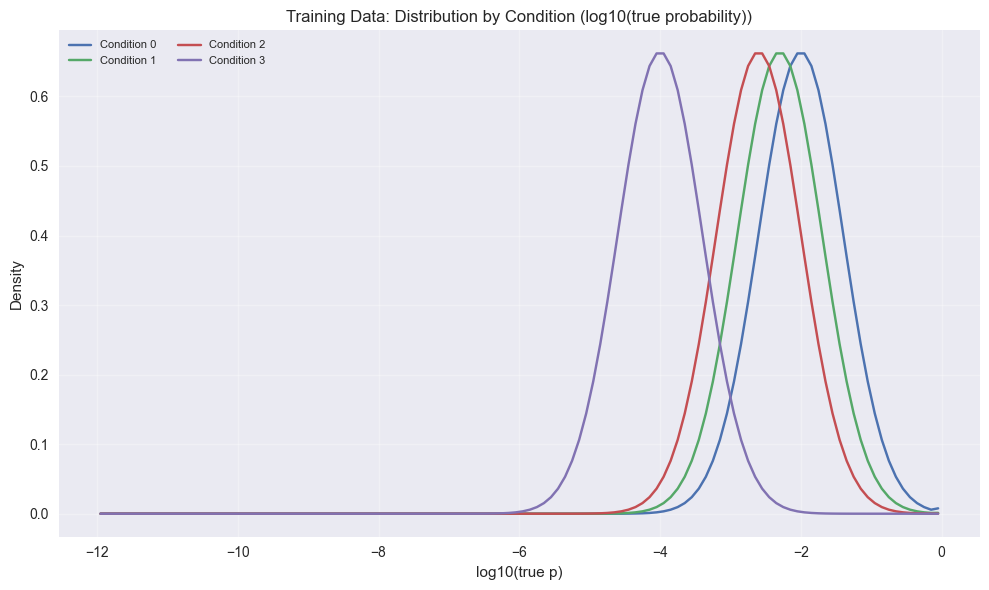

In [2]:
"""Prepare data loaders, resolve eval split, and plot pre-training data distributions."""
data_bundle = prepare_data(cfg, device, use_cuda, use_mps)
splits = data_bundle.splits
loaders = data_bundle.loaders
plots_cfg = cfg['plots']
train_cfg = cfg['training']
data_source = get_data_source(cfg)
condition_label = get_condition_label(cfg)
loss_modes = resolve_loss_modes(train_cfg.get('loss_mode', 'localized_entropy'))
if not loss_modes:
    raise ValueError(f"Unsupported loss_mode: {train_cfg.get('loss_mode')}")
train_multi = len(loss_modes) > 1
train_bce_le = ("bce" in loss_modes and "localized_entropy" in loss_modes)
output_paths = {loss_mode: build_output_paths(cfg, loss_mode) for loss_mode in loss_modes}
if train_multi:
    print(f"Training loss modes: {', '.join(loss_modes)}")
raw_eval_value_range = plots_cfg.get('eval_pred_value_range', [-12, 0])
if isinstance(raw_eval_value_range, (list, tuple)) and len(raw_eval_value_range) == 2:
    eval_value_range = tuple(raw_eval_value_range)
else:
    print("[WARN] plots.eval_pred_value_range should be a 2-item list; using default (-12, 0).")
    eval_value_range = (-12, 0)
# Configure evaluation target via configs/default.json -> evaluation.split.
# Keep a train-time eval split with labels/conds for plots even if eval/test lacks labels.
# Resolve evaluation split + training eval split (for labeled diagnostics)
eval_cfg = cfg.get('evaluation', {})
eval_split, eval_loader, eval_labels, eval_conds, eval_name = resolve_eval_bundle(
    cfg, splits, loaders
)
eval_has_labels = eval_labels is not None
train_eval_loader, train_eval_conds, train_eval_name = resolve_train_eval_bundle(
    eval_split,
    eval_loader,
    eval_labels,
    eval_conds,
    eval_name,
    loaders,
    splits,
)
le_base_rates_train = None
le_base_rates_train_eval = None
le_base_rates_eval = None
use_true_le_base_rates = False
# Optional: use true synthetic base rates for LE denominator
if data_source == 'synthetic' and cfg.get('synthetic', {}).get('use_true_base_rates_for_le', False):
    base_rates_train = per_condition_mean(splits.p_train, splits.c_train, splits.num_conditions)
    base_rates_eval = per_condition_mean(splits.p_eval, splits.c_eval, splits.num_conditions)
    if base_rates_train is not None:
        use_true_le_base_rates = True
        le_base_rates_train = base_rates_train
        le_base_rates_train_eval = base_rates_train if train_eval_name == 'Train' else base_rates_eval
        if eval_name == 'Train':
            le_base_rates_eval = base_rates_train
        elif eval_name == 'Eval':
            le_base_rates_eval = base_rates_eval
        else:
            le_base_rates_eval = None
        print('[INFO] Using true per-condition base rates for LE denominator (synthetic).')
# Logging: split selection and loader notes
if cfg.get('logging', {}).get('print_eval_split', True):
    print(f"Evaluation split: {eval_name}")
    if train_eval_name != eval_name:
        print(f"Training eval split: {train_eval_name}")
if cfg.get('logging', {}).get('print_loader_note', True):
    print(loaders.loader_note)
# Optional CTR filter stats plot
if data_source == 'ctr' and cfg.get('ctr', {}).get('plot_filter_stats', False):
    ctr_stats = data_bundle.plot_data.get('ctr_stats')
    if ctr_stats:
        plot_ctr_filter_stats(ctr_stats['stats_df'], ctr_stats['labels'], ctr_stats['filter_col'])
# Optional pre-training data distribution plots
if plots_cfg.get('data_before_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        if plots_cfg.get('ctr_data_distributions', True):
            ctr_plot = data_bundle.plot_data.get('ctr_distributions')
            if ctr_plot:
                
                print("DEBUG")
                print(ctr_plot['feature_names'])
                print(ctr_plot['num_conditions'])
                # Skip high-cardinality device count features to keep plots readable.
                skip_features = {"device_ip_count", "device_id_count"}
                feature_names = [
                    name for name in ctr_plot['feature_names'] if name not in skip_features
                ]
                if feature_names:
                    feature_indices = [
                        i
                        for i, name in enumerate(ctr_plot['feature_names'])
                        if name not in skip_features
                    ]
                    filtered_xnum = ctr_plot['xnum'][:, feature_indices]
                    # Apply log scaling only to configured numeric features.
                    log10_features = set(plots_cfg.get('ctr_log10_features', []))
                    log10_features &= set(feature_names)
                    plot_feature_distributions_by_condition(
                        filtered_xnum,
                        ctr_plot['conds'],
                        feature_names,
                        ctr_plot['num_conditions'],
                        max_features=int(plots_cfg.get('ctr_max_features', 3)),
                        log10_features=log10_features,
                        density=bool(plots_cfg.get('ctr_use_density', False)),
                    )
                else:
                    print('CTR distribution plots: all features filtered; skipping.')
                if plots_cfg.get('ctr_label_rates', True):
                    plot_label_rates_by_condition(
                        ctr_plot['labels'],
                        ctr_plot['conds'],
                        ctr_plot['num_conditions'],
                    )
            else:
                print('CTR plot_sample_size is disabled or empty; skipping CTR distributions.')
        else:
            print('CTR distribution plots are disabled in config.')
else:
    print('Skipping training data distribution plots before training.')


In [3]:
"""Print diagnostic stats for features, conditions, and labels."""
# Split-level diagnostics: features, conditions, and labels
# Diagnostics: input/label/condition stats
from localized_entropy.analysis import (
    print_condition_stats,
    print_feature_stats,
    print_label_stats,
)

print('Diagnostics: splits')
# Feature distributions per split
print_feature_stats('Train features', splits.x_train)
print_feature_stats('Eval features', splits.x_eval)
if splits.x_test is not None:
    print_feature_stats('Test features', splits.x_test)

# Condition counts per split
print_condition_stats('Train conds', splits.c_train, splits.num_conditions)
print_condition_stats('Eval conds', splits.c_eval, splits.num_conditions)
if splits.c_test is not None:
    print_condition_stats('Test conds', splits.c_test, splits.num_conditions)

# Label base rates per split
print_label_stats('Train labels', splits.y_train, splits.c_train, splits.num_conditions)
print_label_stats('Eval labels', splits.y_eval, splits.c_eval, splits.num_conditions)
if splits.y_test is not None:
    print_label_stats('Test labels', splits.y_test, splits.c_test, splits.num_conditions)


Diagnostics: splits
Train features: shape=(10800000, 3)
  mean: min=0.00552862 max=0.174909 avg=0.0633947
  std:  min=0.984277 max=0.999724 avg=0.994348
  std < 1e-8: 0.00%
Eval features: shape=(1200000, 3)
  mean: min=0.00551727 max=0.174773 avg=0.0635521
  std:  min=0.992946 max=1.03488 avg=1.0113
  std < 1e-8: 0.00%
Train conds: n=10,800,000 unique=4 min=0 max=3
  counts: min=2699631 max=2700475 mean=2700000.00 zeros=0
Eval conds: n=1,200,000 unique=4 min=0 max=3
  counts: min=299525 max=300369 mean=300000.00 zeros=0
Train labels: n=10,800,000 base_rate=0.011411 min=0 max=1
  per-cond base_rate: min=0.000261065 max=0.0258758 avg=0.0114119
Eval labels: n=1,200,000 base_rate=0.0115183 min=0 max=1
  per-cond base_rate: min=0.000273767 max=0.0262377 avg=0.0115101


In [4]:
"""Build model instances for each requested loss mode."""
models = {}
for loss_mode in loss_modes:
    set_seed(cfg['project']['seed'], use_cuda, deterministic=deterministic_flag)
    model = build_model(cfg, splits, device, dtype=model_dtype)
    models[loss_mode] = model
    if len(loss_modes) == 1:
        model
    else:
        print(f"Model ({loss_label(loss_mode)}):")
        print(model)


Model (BCE):
ConditionProbNet(
  (embedding): Embedding(4, 16)
  (cat_embeddings): ModuleList()
  (net): Sequential(
    (0): Linear(in_features=19, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)
Model (LE):
ConditionProbNet(
  (embedding): Embedding(4, 16)
  (cat_embeddings): ModuleList()
  (net): Sequential(
    (0): Linear(in_features=19, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)


In [5]:
"""Check initial logits/probabilities before training."""
# Use a single batch to sanity-check untrained logits/probabilities
# Diagnostics: initial logits/prob stats (untrained)
try:
    batch = next(iter(train_eval_loader))
except StopIteration:
    batch = None
if batch is None:
    print(f"{train_eval_name} loader empty; skipping init logits diagnostics.")
else:
    # Batch includes per-sample weights (ignored for init diagnostics)
    x_b, x_cat_b, c_b, y_b, _ = batch
    x_b = x_b.to(device, non_blocking=non_blocking)
    x_cat_b = x_cat_b.to(device, non_blocking=non_blocking)
    c_b = c_b.to(device, non_blocking=non_blocking)
    for loss_mode, model in models.items():
        label = loss_label(loss_mode)
        with torch.no_grad():
            logits = model(x_b, x_cat_b, c_b)
            probs = torch.sigmoid(logits)
        logits_np = logits.detach().cpu().numpy().reshape(-1)
        probs_np = probs.detach().cpu().numpy().reshape(-1)
        print(
            f"{label} init batch logits: n={logits_np.size:,} min={logits_np.min():.6g} "
            f"max={logits_np.max():.6g} mean={logits_np.mean():.6g} std={logits_np.std():.6g}"
        )
        print(
            f"{label} init batch probs:  n={probs_np.size:,} min={probs_np.min():.6g} "
            f"max={probs_np.max():.6g} mean={probs_np.mean():.6g} std={probs_np.std():.6g}"
        )


BCE init batch logits: n=25,000 min=-0.399459 max=0.243297 mean=-0.00048324 std=0.0303978
BCE init batch probs:  n=25,000 min=0.401442 max=0.560526 mean=0.499879 std=0.00759621
LE init batch logits: n=25,000 min=-0.362945 max=0.265859 mean=-0.000669401 std=0.0302972
LE init batch probs:  n=25,000 min=0.410247 max=0.566076 mean=0.499833 std=0.00757158
Focal init batch logits: n=25,000 min=-0.514954 max=0.126667 mean=-0.000391141 std=0.0307736
Focal init batch probs:  n=25,000 min=0.374033 max=0.531625 mean=0.499903 std=0.00768776


Pre-Training Eval (BCE) prediction stats per condition:
  cond 0: n=300369 min=0.459638 max=0.504873 mean=0.503371
  cond 1: n=299935 min=0.461344 max=0.505706 mean=0.500984
  cond 2: n=300171 min=0.449437 max=0.504199 mean=0.500681
  cond 3: n=299525 min=0.419933 max=0.503628 mean=0.502457
Eval predictions per condition: [300369, 299935, 300171, 299525]


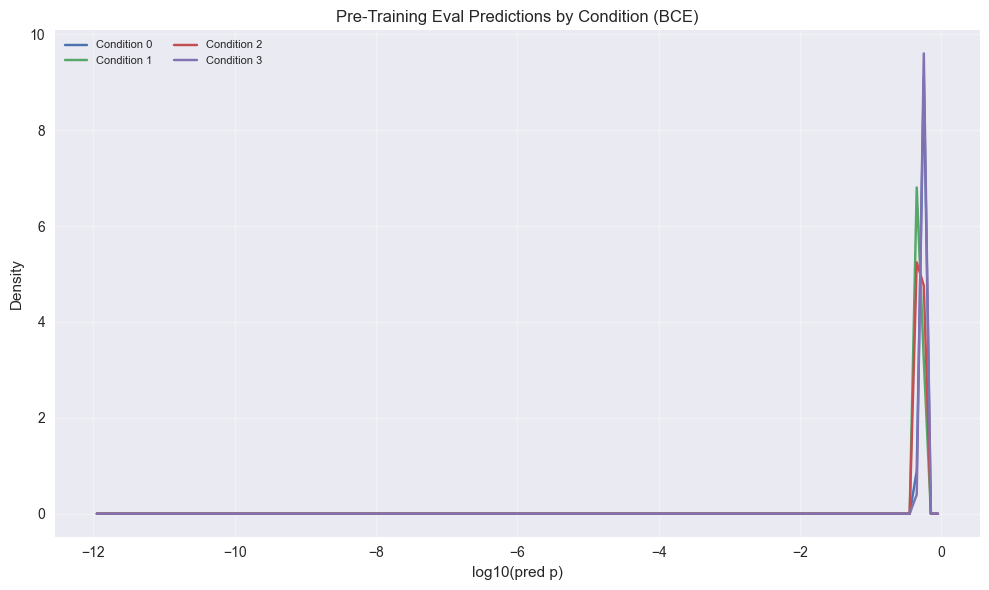

Pre-Training Eval (LE) prediction stats per condition:
  cond 0: n=300369 min=0.459638 max=0.504873 mean=0.503371
  cond 1: n=299935 min=0.461344 max=0.505706 mean=0.500984
  cond 2: n=300171 min=0.449437 max=0.504199 mean=0.500681
  cond 3: n=299525 min=0.419933 max=0.503628 mean=0.502457
Eval predictions per condition: [300369, 299935, 300171, 299525]


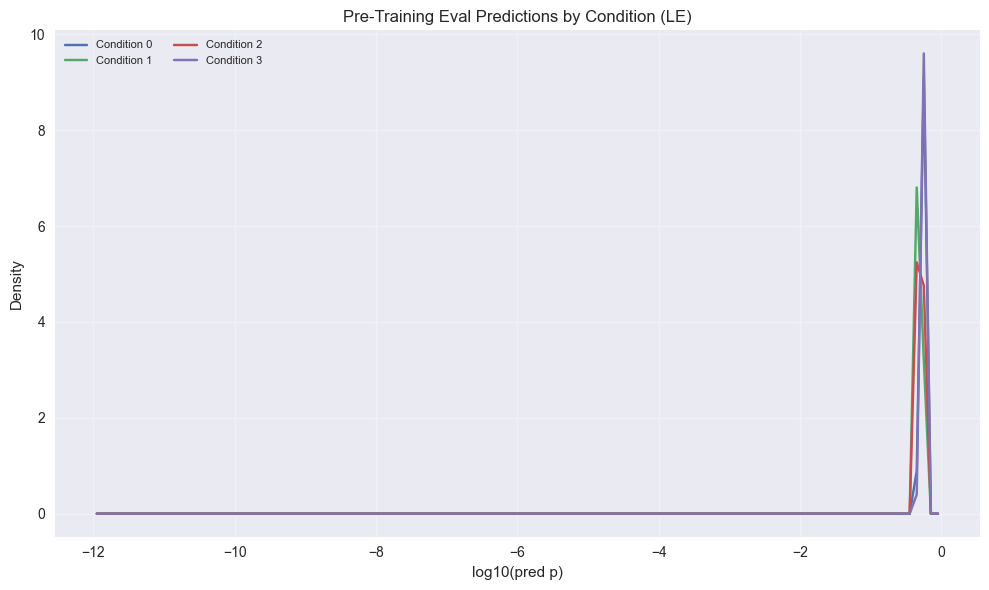

Pre-Training Eval (Focal) prediction stats per condition:
  cond 0: n=300369 min=0.459638 max=0.504873 mean=0.503371
  cond 1: n=299935 min=0.461344 max=0.505706 mean=0.500984
  cond 2: n=300171 min=0.449437 max=0.504199 mean=0.500681
  cond 3: n=299525 min=0.419933 max=0.503628 mean=0.502457
Eval predictions per condition: [300369, 299935, 300171, 299525]


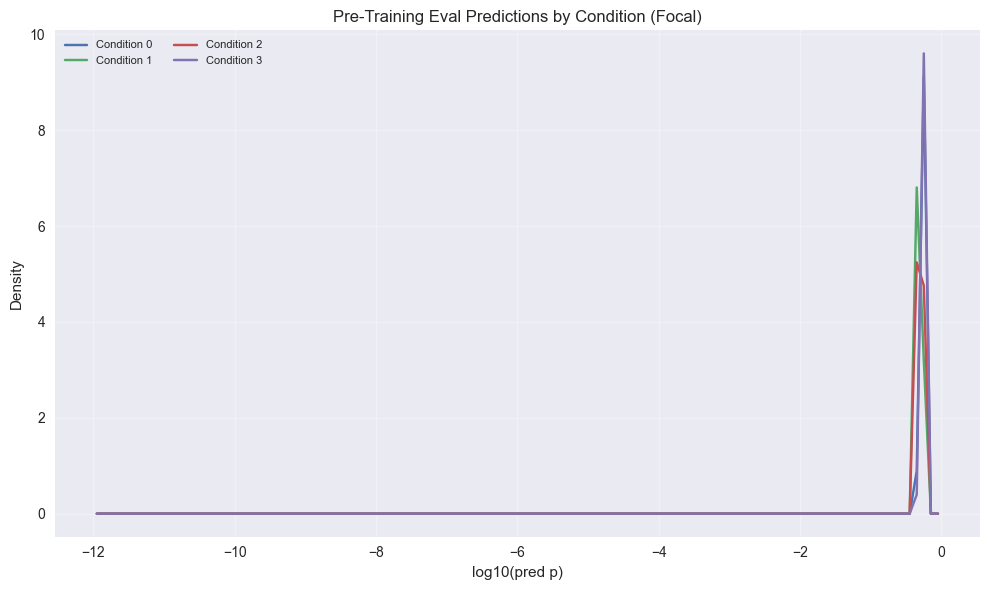

In [6]:
"""Inspect pre-training predictions by condition when enabled."""
if plots_cfg.get('eval_pred_by_condition', True):
    for loss_mode, model in models.items():
        loss_name = loss_label(loss_mode)
        pretrain_eval_preds = predict_probs(
            model,
            train_eval_loader,
            device,
            non_blocking=non_blocking,
        )
        if pretrain_eval_preds.size > 0:
            if train_eval_conds is None:
                print(f"{train_eval_name} conditions unavailable; skipping per-condition stats.")
            else:
                print_pred_stats_by_condition(
                    pretrain_eval_preds,
                    train_eval_conds,
                    splits.num_conditions,
                    name=f"Pre-Training {train_eval_name} ({loss_name})",
                )
                plot_eval_predictions_by_condition(
                    pretrain_eval_preds,
                    train_eval_conds,
                    splits.num_conditions,
                    value_range=eval_value_range,
                    title=(
                        f"Pre-Training {train_eval_name} Predictions by {condition_label} ("
                        f"{loss_name})"
                    ),
                )
        else:
            print(f"{train_eval_name} set is empty after filtering; skipping pre-training plot.")


Staging datasets directly on CUDA for batch sampling.
Staging datasets directly on CUDA for batch sampling.
Staging datasets directly on CUDA for batch sampling.
[INFO] Training BCE model


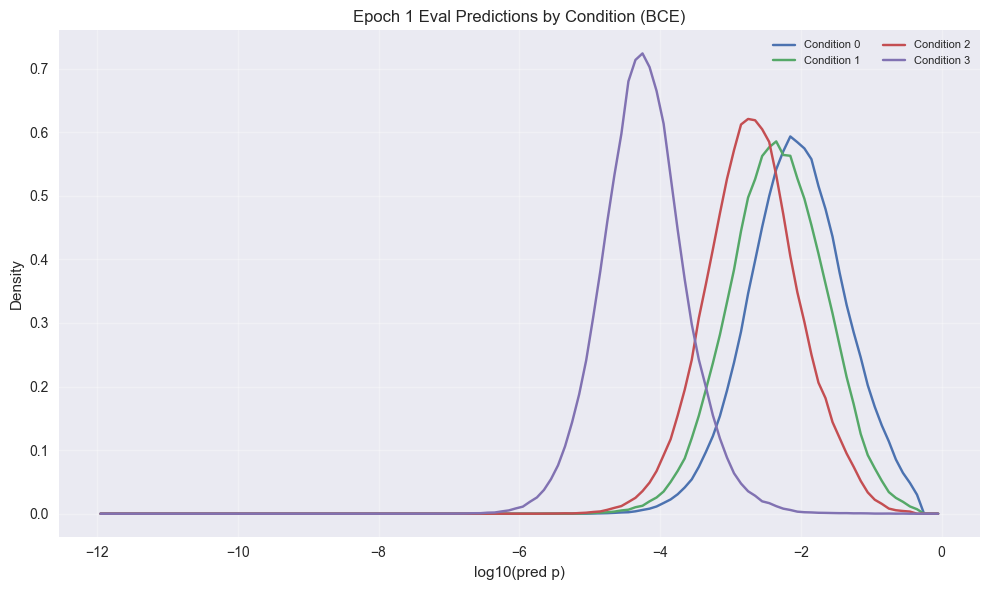

Epoch   1/5 | Train BCE: 0.061092 | Eval BCE: 0.047306 | wall 1.81s | cuda_mem=1377.6MB (peak 1645.3MB)
Epoch   1 embedding table:
[[ 1.9227,  1.4775,  0.8591, -2.0995,  0.673 , -1.2244, -0.0235, -1.5918,
  -0.7432,  1.6394, -0.3792, -1.3923, -0.7262, -0.5423, -0.7673,  0.7582],
 [ 1.6413, -0.1105, -0.4967,  0.4269, -0.7465,  1.0729,  0.8003,  1.6806,
   1.2645,  1.303 ,  0.6018,  1.3316, -0.2235,  0.0346, -0.2493,  0.8632],
 [-1.3672, -0.836 , -0.2046,  1.7119,  0.3439, -0.4989,  0.3379, -0.7639,
  -1.5543,  1.0214, -0.8769, -0.6239, -1.2666,  2.1131, -1.2312, -0.5072],
 [-0.944 , -0.7165,  0.0496,  0.557 , -0.5357,  1.2212, -0.8508, -0.7631,
  -1.4302, -0.0008, -0.0345,  0.7102, -0.0776,  1.8742, -1.2142,  1.4147]]


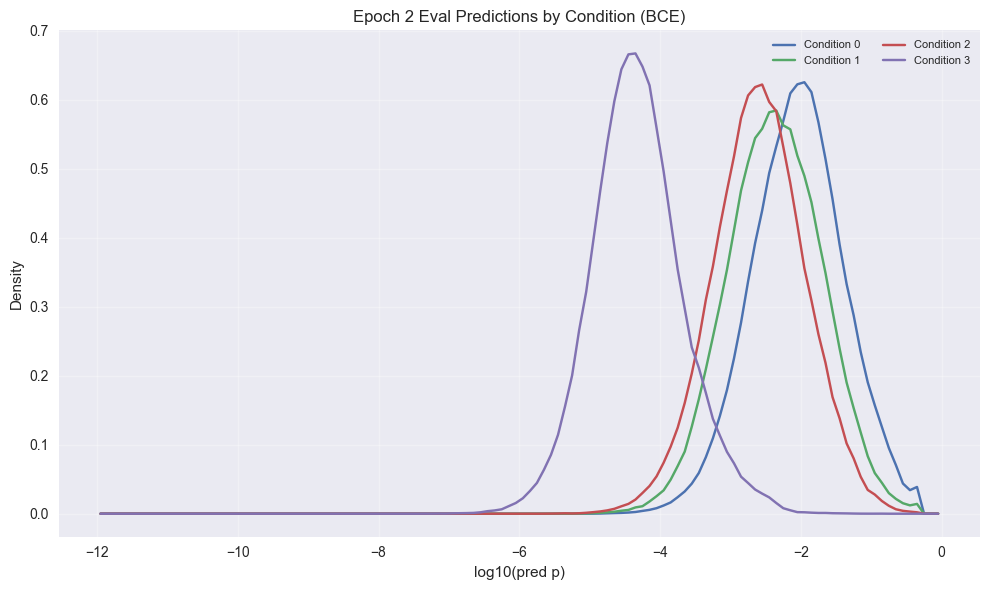

Epoch   2/5 | Train BCE: 0.048685 | Eval BCE: 0.047120 | wall 1.70s | cuda_mem=1377.6MB (peak 1645.3MB)
Epoch   2 embedding table:
[[ 1.9149,  1.4688,  0.8585, -2.0922,  0.6772, -1.2145, -0.0224, -1.5872,
  -0.7402,  1.6361, -0.3703, -1.3864, -0.7208, -0.5321, -0.7654,  0.7544],
 [ 1.6342, -0.1187, -0.4889,  0.441 , -0.7386,  1.0658,  0.7953,  1.676 ,
   1.2551,  1.3094,  0.5981,  1.3288, -0.2519,  0.0435, -0.2529,  0.8569],
 [-1.3576, -0.8318, -0.2055,  1.7061,  0.3378, -0.4993,  0.3547, -0.7596,
  -1.5496,  1.032 , -0.8811, -0.6172, -1.2741,  2.1066, -1.2295, -0.5042],
 [-0.9436, -0.7094,  0.0456,  0.5605, -0.5437,  1.2223, -0.8544, -0.7655,
  -1.4312, -0.0027, -0.034 ,  0.7112, -0.0788,  1.8763, -1.2156,  1.4169]]


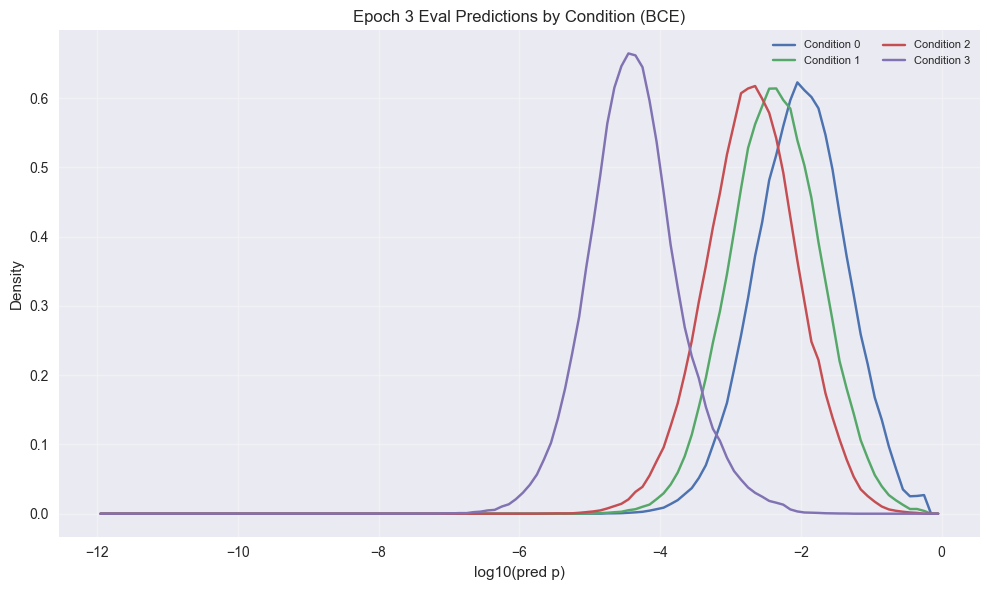

Epoch   3/5 | Train BCE: 0.048357 | Eval BCE: 0.047043 | wall 1.63s | cuda_mem=1377.6MB (peak 1645.3MB)
Epoch   3 embedding table:
[[ 1.908 ,  1.4654,  0.8497, -2.0846,  0.6734, -1.2064, -0.0137, -1.5817,
  -0.7365,  1.6353, -0.3676, -1.377 , -0.7235, -0.526 , -0.7634,  0.7442],
 [ 1.6286, -0.118 , -0.4838,  0.444 , -0.7323,  1.0617,  0.7955,  1.6676,
   1.2394,  1.3105,  0.5981,  1.3202, -0.2597,  0.0612, -0.2596,  0.8524],
 [-1.3493, -0.8196, -0.2008,  1.7025,  0.3381, -0.4995,  0.354 , -0.7559,
  -1.5484,  1.0377, -0.8844, -0.6115, -1.2677,  2.1027, -1.228 , -0.5164],
 [-0.9426, -0.7165,  0.0405,  0.5628, -0.5553,  1.2246, -0.858 , -0.7672,
  -1.4326, -0.0047, -0.0372,  0.7139, -0.0834,  1.8794, -1.2173,  1.4197]]


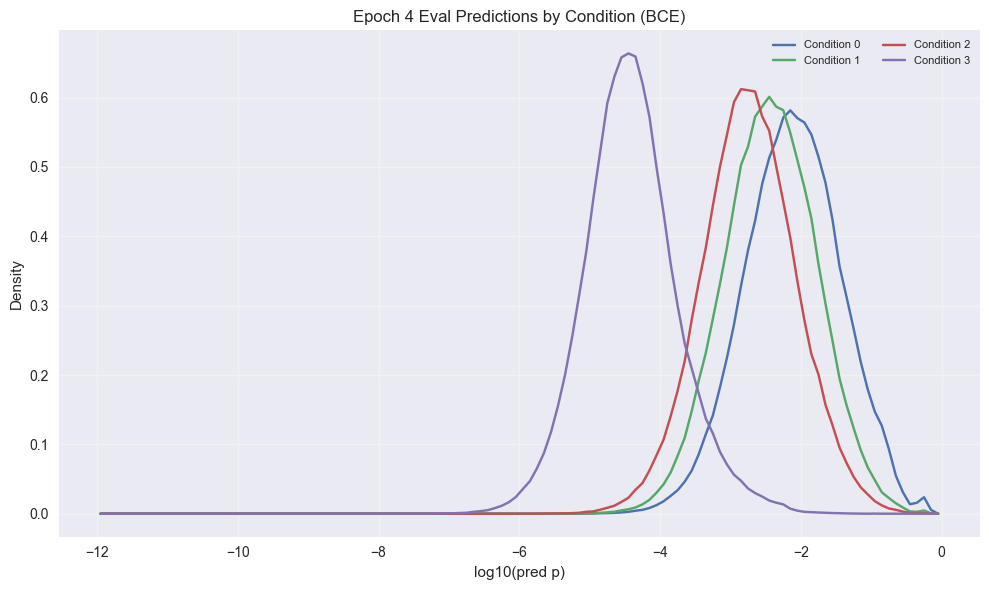

Epoch   4/5 | Train BCE: 0.048184 | Eval BCE: 0.047088 | wall 1.43s | cuda_mem=1377.6MB (peak 1645.3MB)
Epoch   4 embedding table:
[[ 1.9002,  1.4566,  0.8443, -2.0796,  0.6742, -1.1955, -0.0158, -1.5739,
  -0.7305,  1.6302, -0.3598, -1.3677, -0.718 , -0.5224, -0.7609,  0.7422],
 [ 1.6232, -0.1264, -0.4773,  0.4401, -0.7296,  1.0525,  0.7909,  1.6601,
   1.2326,  1.3099,  0.589 ,  1.3114, -0.2705,  0.0687, -0.2625,  0.8467],
 [-1.339 , -0.8195, -0.1951,  1.6962,  0.3288, -0.5014,  0.3546, -0.7518,
  -1.5421,  1.039 , -0.8791, -0.6154, -1.2597,  2.0964, -1.2264, -0.5095],
 [-0.9418, -0.7079,  0.0356,  0.5636, -0.563 ,  1.2252, -0.8576, -0.7691,
  -1.4337, -0.0062, -0.0418,  0.7143, -0.0896,  1.8817, -1.2184,  1.4203]]


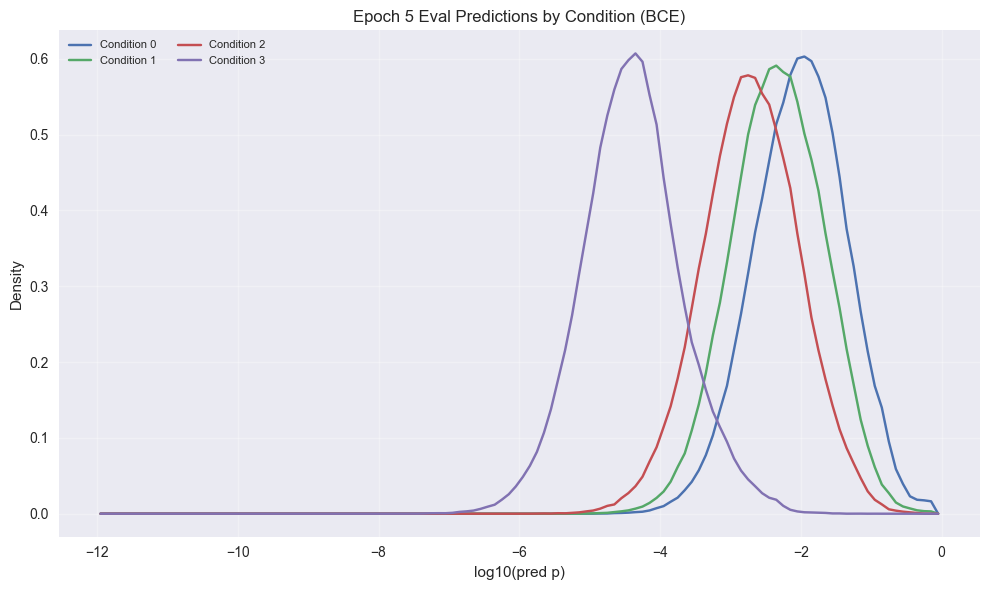

Epoch   5/5 | Train BCE: 0.048074 | Eval BCE: 0.046981 | wall 1.42s | cuda_mem=1377.6MB (peak 1645.3MB)
Epoch   5 embedding table:
[[ 1.8905,  1.4432,  0.8302, -2.0691,  0.6736, -1.1883, -0.0257, -1.5713,
  -0.7265,  1.6268, -0.3413, -1.3599, -0.7173, -0.5103, -0.7565,  0.7361],
 [ 1.6178, -0.1238, -0.4726,  0.4342, -0.7214,  1.0417,  0.7934,  1.6503,
   1.2173,  1.3069,  0.5831,  1.3049, -0.2611,  0.0749, -0.2699,  0.8427],
 [-1.3281, -0.8104, -0.1966,  1.69  ,  0.3333, -0.5085,  0.3645, -0.7449,
  -1.5371,  1.0507, -0.8734, -0.6162, -1.2556,  2.0941, -1.2239, -0.5188],
 [-0.9421, -0.7108,  0.0285,  0.5631, -0.5751,  1.227 , -0.8615, -0.771 ,
  -1.4357, -0.0099, -0.046 ,  0.7147, -0.0934,  1.8841, -1.2216,  1.4223]]
Final Train BCE: 0.0480740107
Final Eval  BCE: 0.0469811943
[INFO] Training LE model


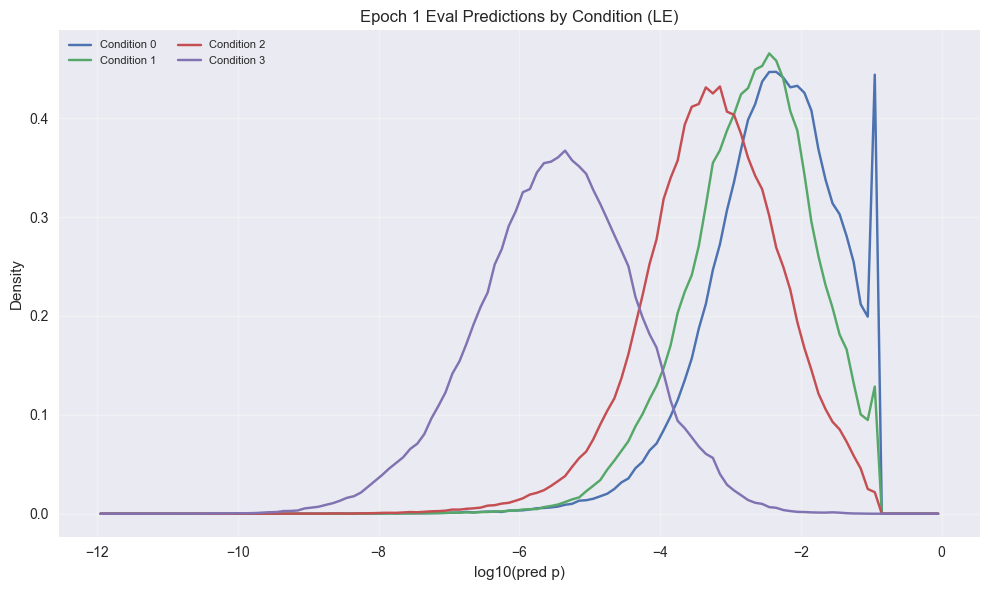

Epoch   1/5 | Train LE: 0.000131 | Eval LE: 0.000071 | wall 11.61s | cuda_mem=1379.9MB (peak 1829.0MB)
Epoch   1 embedding table:
[[ 1.6886,  1.0862,  0.1729, -1.7477,  0.1074, -0.7882,  0.0122, -1.216 ,
  -0.4611,  1.4806,  0.0169, -0.9249, -0.5518,  0.103 , -0.6466,  0.6553],
 [ 1.4087,  0.0412, -0.1511,  0.1956, -0.3217,  0.7932,  0.4417,  1.1394,
   0.9837,  1.2564,  0.1605,  0.9342, -0.3722,  0.0948, -0.2679,  0.6594],
 [-1.0328, -0.4061,  0.1469,  1.3629,  0.2428, -0.5481,  0.3406, -0.4574,
  -1.283 ,  0.8586, -0.3937, -0.6264, -0.894 ,  1.7792, -1.0429, -0.291 ],
 [-0.5444, -0.3082, -0.081 ,  0.5097, -0.0752,  0.7873, -0.5787, -0.3035,
  -1.141 ,  0.0579,  0.0567,  0.4337, -0.045 ,  1.4988, -0.9376,  0.9993]]


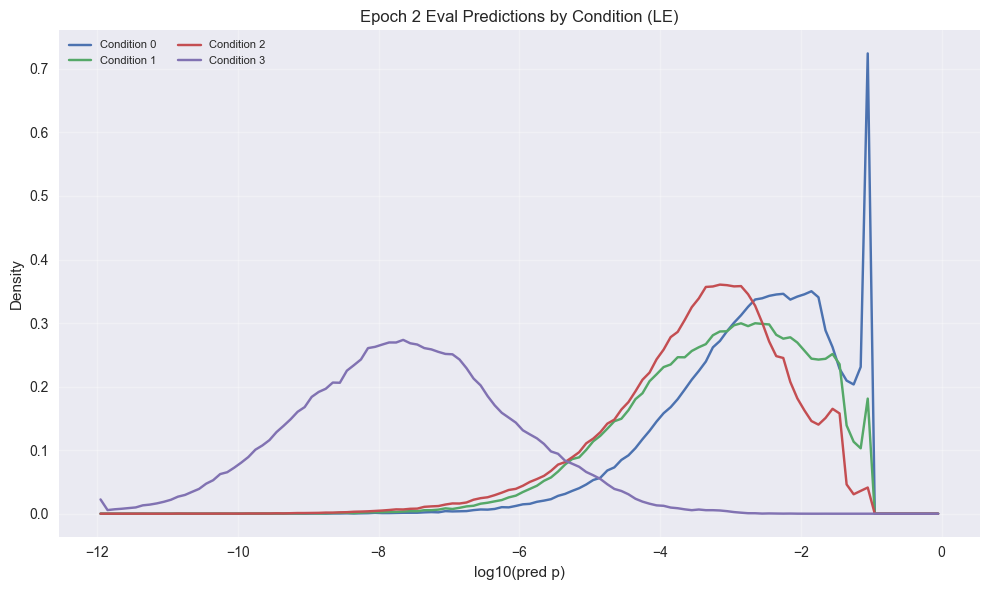

Epoch   2/5 | Train LE: 0.000082 | Eval LE: 0.000080 | wall 11.00s | cuda_mem=1379.9MB (peak 1829.0MB)
Epoch   2 embedding table:
[[ 1.6216,  0.8293, -0.0247, -1.5941, -0.0139, -0.6557,  0.1889, -1.044 ,
  -0.3298,  1.3415,  0.0491, -0.7473, -0.3824,  0.0298, -0.5584,  0.5511],
 [ 1.4101,  0.0478, -0.0717, -0.2747, -0.0091,  0.5192,  0.4754,  0.957 ,
   1.0893,  1.2318, -0.0327,  0.6511, -0.3677, -0.1396, -0.0654,  0.3395],
 [-0.6983, -0.212 ,  0.188 ,  0.9813,  0.1541, -0.7046,  0.5076, -0.2055,
  -0.9467,  0.8857, -0.1554, -0.6549, -0.6365,  1.4491, -0.8449, -0.4152],
 [-0.6556, -0.2023,  0.1996,  0.5292,  0.003 ,  0.7789, -0.5829, -0.3364,
  -1.1025, -0.0317,  0.0213,  0.3852,  0.0588,  1.3804, -0.843 ,  0.682 ]]


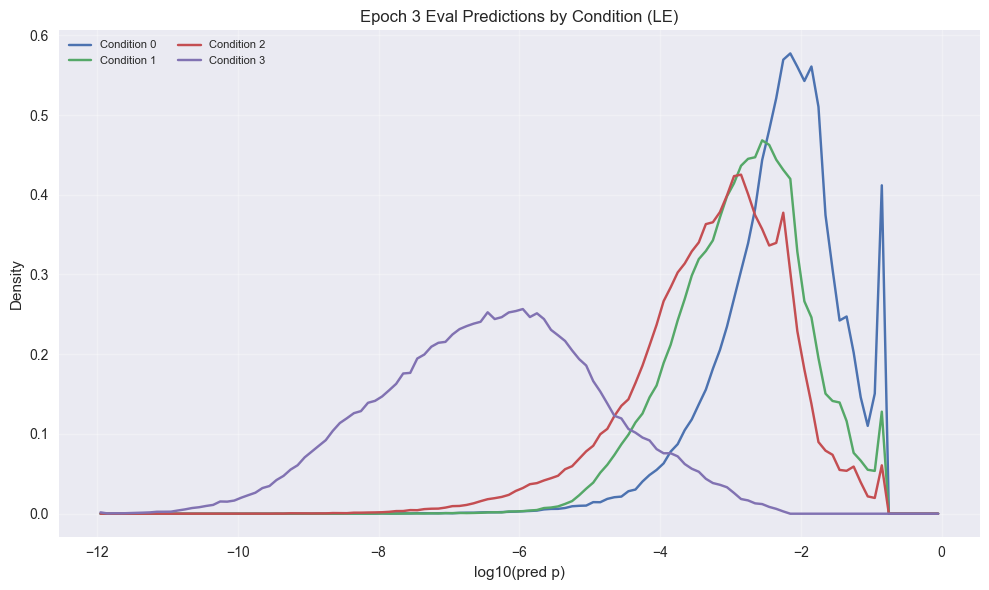

Epoch   3/5 | Train LE: 0.000077 | Eval LE: 0.000073 | wall 11.41s | cuda_mem=1379.9MB (peak 1829.0MB)
Epoch   3 embedding table:
[[ 1.5303,  0.7275, -0.0534, -1.4876, -0.029 , -0.568 , -0.0844, -0.9801,
  -0.3304,  1.2351,  0.037 , -0.5953, -0.281 ,  0.0511, -0.4923,  0.503 ],
 [ 1.3563,  0.0048, -0.0594, -0.2057,  0.0074,  0.4953,  0.357 ,  0.8795,
   1.0064,  1.2348,  0.0007,  0.6289, -0.3565, -0.1352, -0.1143,  0.3294],
 [-0.5527, -0.1242, -0.1065,  0.8708, -0.0283, -0.7686,  0.5218, -0.072 ,
  -0.805 ,  0.8676, -0.0313, -0.6645, -0.664 ,  1.3003, -0.7888, -0.3272],
 [-0.6238, -0.1637,  0.0678,  0.4767,  0.0352,  0.7022, -0.4601, -0.244 ,
  -0.9967, -0.0171, -0.0775,  0.293 , -0.0319,  1.3292, -0.7443,  0.5261]]


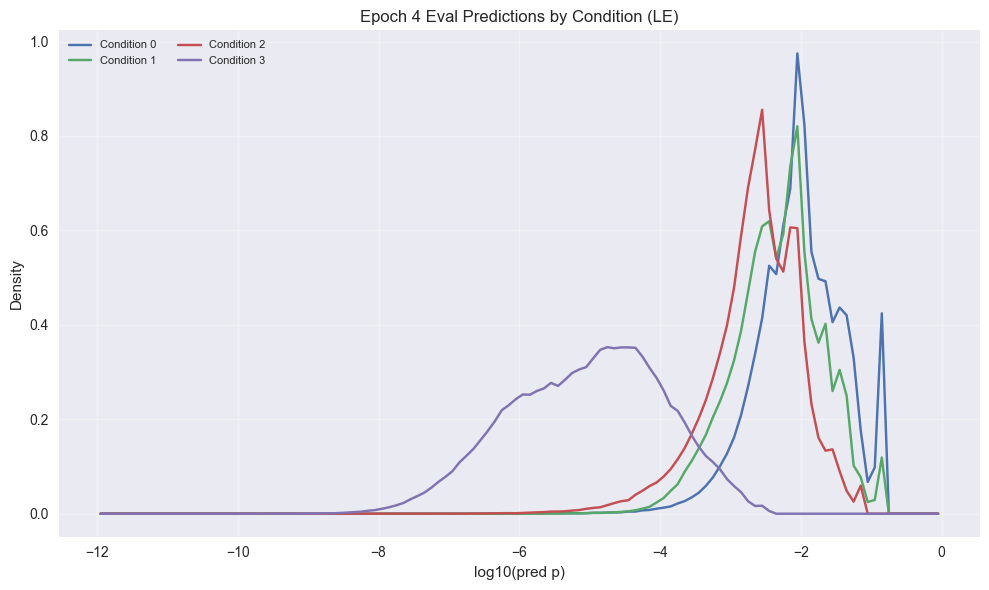

Epoch   4/5 | Train LE: 0.000079 | Eval LE: 0.000069 | wall 11.18s | cuda_mem=1379.9MB (peak 1829.0MB)
Epoch   4 embedding table:
[[ 1.474 ,  0.6201,  0.0027, -1.4289, -0.0548, -0.5336,  0.0826, -0.8776,
  -0.2676,  1.1652,  0.0057, -0.4887, -0.2291, -0.1527, -0.4023,  0.3925],
 [ 1.3887, -0.0642, -0.0243, -0.3403,  0.0144,  0.2979,  0.4856,  0.7514,
   0.8925,  1.2025, -0.0526,  0.5151, -0.4025, -0.2181, -0.0505,  0.2947],
 [-0.3501,  0.0141,  0.0127,  0.5877,  0.1013, -0.8615,  0.6769, -0.019 ,
  -0.5294,  0.9204,  0.0175, -0.6183, -0.5713,  1.0629, -0.6331, -0.294 ],
 [-0.5536, -0.0361,  0.0233,  0.2802,  0.0084,  0.5794, -0.3235, -0.0397,
  -0.7166,  0.0566,  0.0959,  0.1559, -0.072 ,  0.8657, -0.5912,  0.2994]]


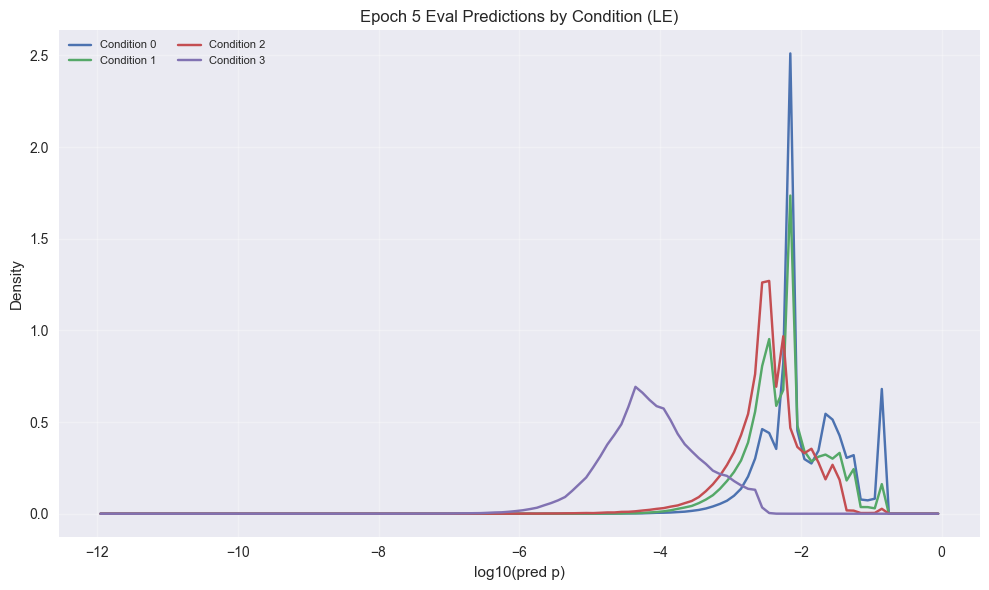

Epoch   5/5 | Train LE: 0.000076 | Eval LE: 0.000068 | wall 10.96s | cuda_mem=1379.9MB (peak 1829.0MB)
Epoch   5 embedding table:
[[ 1.3809,  0.4349, -0.0005, -1.2785, -0.0909, -0.4656,  0.0871, -0.821 ,
  -0.2123,  1.1183, -0.0044, -0.4545, -0.1893, -0.2451, -0.3441,  0.3249],
 [ 1.3681, -0.0645,  0.0545, -0.3079,  0.0676,  0.207 ,  0.4853,  0.6759,
   0.8602,  1.1705, -0.089 ,  0.4321, -0.3185, -0.2869,  0.0397,  0.2411],
 [-0.3058,  0.0599,  0.0022,  0.5149,  0.0962, -0.9466,  0.7727,  0.0531,
  -0.3903,  0.9574,  0.0209, -0.5843, -0.5966,  0.9174, -0.5753, -0.38  ],
 [-0.4756,  0.0145, -0.0079,  0.1783, -0.0655,  0.5886, -0.3334, -0.0725,
  -0.6965, -0.0694,  0.1213,  0.2038,  0.1005,  0.7627, -0.2032,  0.2653]]
Final Train LE: 0.0000756417
Final Eval  LE: 0.0000682608
[INFO] Training Focal model


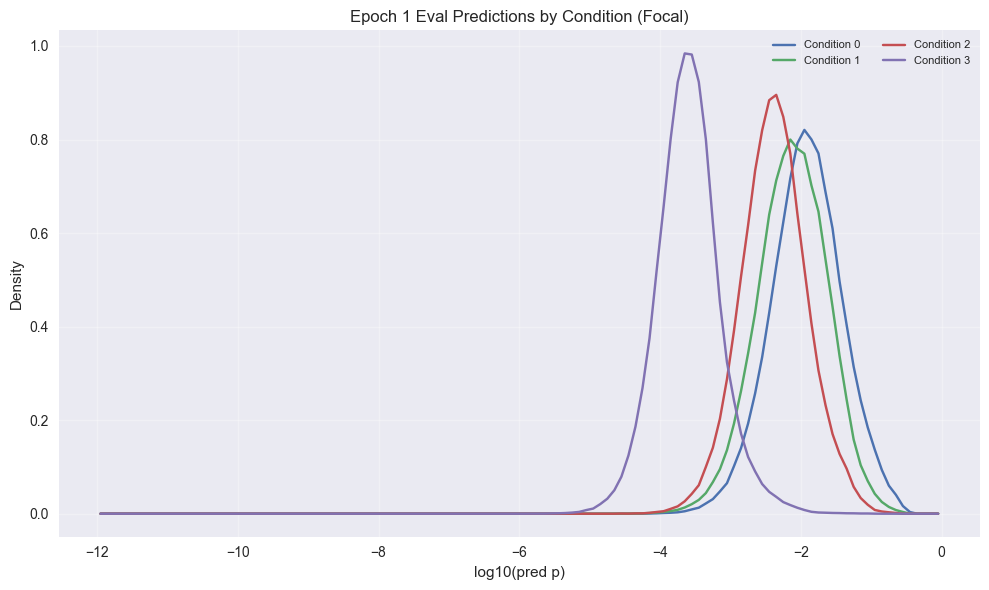

Epoch   1/3 | Train Focal: 0.015163 | Eval Focal: 0.008859 | wall 1.64s | cuda_mem=1378.4MB (peak 1646.1MB)
Epoch   1 embedding table:
[[ 1.9254,  1.4849,  0.8751, -2.1041,  0.6794, -1.2358, -0.0364, -1.5924,
  -0.7434,  1.6412, -0.3808, -1.4024, -0.7252, -0.5405, -0.7681,  0.7586],
 [ 1.6462, -0.0924, -0.4973,  0.4157, -0.7469,  1.074 ,  0.8024,  1.6835,
   1.2789,  1.3004,  0.6056,  1.331 , -0.2163,  0.03  , -0.2494,  0.8652],
 [-1.3728, -0.8384, -0.203 ,  1.7132,  0.3397, -0.5111,  0.3405, -0.7664,
  -1.5563,  1.0078, -0.8744, -0.625 , -1.2614,  2.1152, -1.2335, -0.5024],
 [-0.934 , -0.6969,  0.0566,  0.5492, -0.5217,  1.2141, -0.8417, -0.7572,
  -1.4257,  0.0088, -0.0388,  0.7033, -0.0768,  1.8679, -1.2083,  1.4077]]


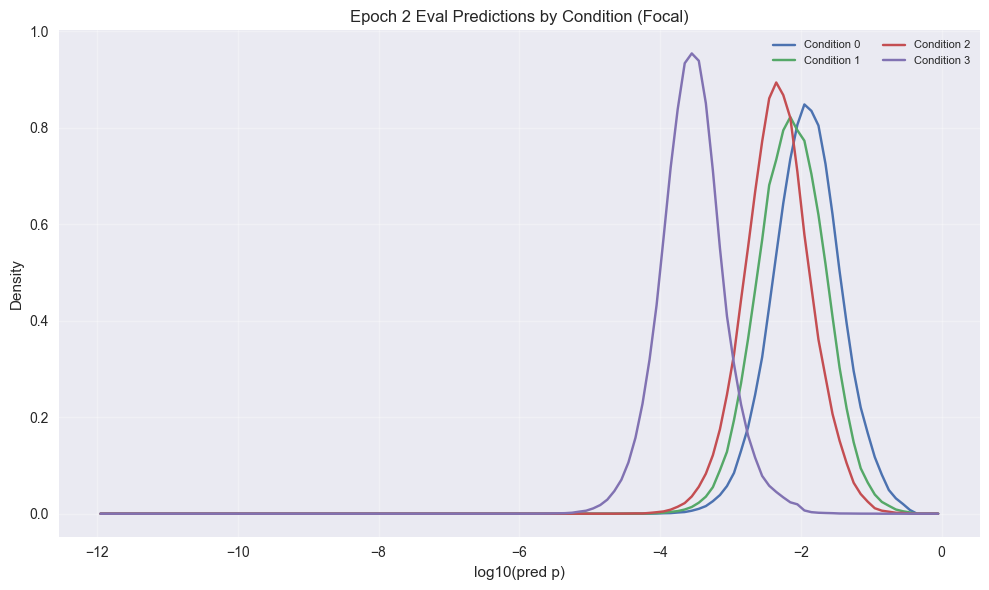

Epoch   2/3 | Train Focal: 0.009281 | Eval Focal: 0.008824 | wall 1.71s | cuda_mem=1378.4MB (peak 1646.1MB)
Epoch   2 embedding table:
[[ 1.9217,  1.4807,  0.869 , -2.0991,  0.679 , -1.2309, -0.0306, -1.5913,
  -0.7407,  1.6399, -0.3749, -1.3996, -0.7204, -0.5333, -0.7676,  0.7552],
 [ 1.6431, -0.0956, -0.4942,  0.4209, -0.7421,  1.0699,  0.8007,  1.6807,
   1.2812,  1.3004,  0.6027,  1.3293, -0.2285,  0.0259, -0.2489,  0.862 ],
 [-1.3654, -0.8307, -0.2112,  1.7091,  0.337 , -0.5133,  0.3478, -0.7643,
  -1.554 ,  1.0133, -0.8769, -0.6216, -1.2653,  2.1121, -1.2324, -0.5037],
 [-0.9318, -0.6823,  0.0552,  0.5489, -0.521 ,  1.2126, -0.8395, -0.7564,
  -1.4251,  0.0108, -0.0391,  0.701 , -0.0796,  1.8676, -1.2078,  1.407 ]]


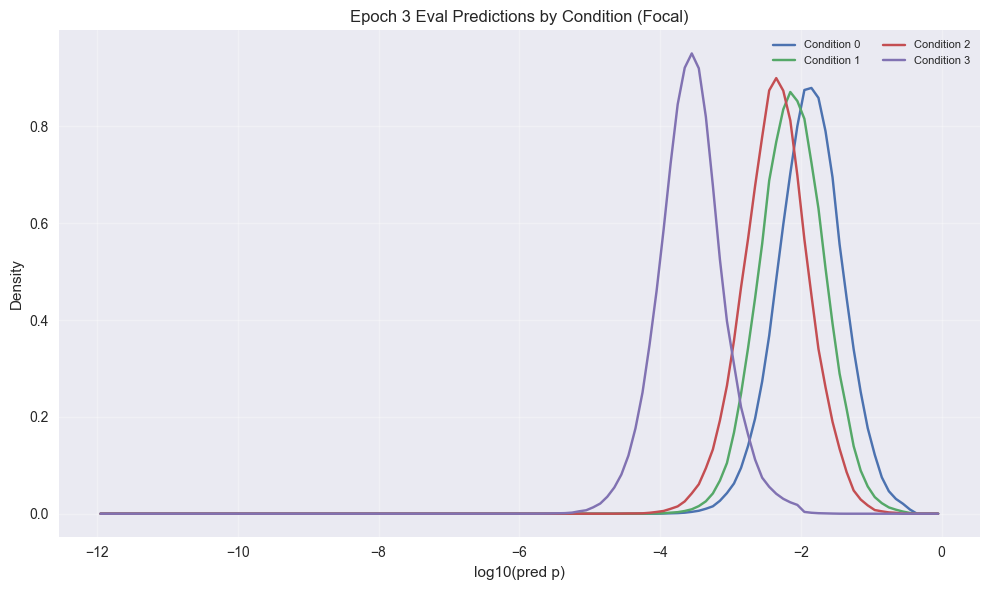

Epoch   3/3 | Train Focal: 0.009198 | Eval Focal: 0.008807 | wall 1.85s | cuda_mem=1378.4MB (peak 1646.1MB)
Epoch   3 embedding table:
[[ 1.9167,  1.4778,  0.8682, -2.094 ,  0.6804, -1.226 , -0.0295, -1.5885,
  -0.7385,  1.6415, -0.3711, -1.3964, -0.7171, -0.5213, -0.7677,  0.748 ],
 [ 1.6402, -0.1021, -0.4916,  0.4221, -0.7377,  1.0678,  0.8013,  1.6774,
   1.2697,  1.3039,  0.6024,  1.3269, -0.2336,  0.0363, -0.2529,  0.8582],
 [-1.36  , -0.8232, -0.2107,  1.7066,  0.3367, -0.5122,  0.3487, -0.7624,
  -1.5527,  1.0189, -0.8808, -0.6203, -1.2652,  2.1097, -1.2317, -0.5091],
 [-0.9307, -0.68  ,  0.0538,  0.5497, -0.5235,  1.2126, -0.8397, -0.7565,
  -1.4253,  0.0118, -0.0412,  0.7012, -0.0826,  1.8683, -1.2081,  1.4071]]
Final Train Focal: 0.0091975348
Final Eval  Focal: 0.0088071931


In [7]:
"""Train models with optional eval callbacks and collect run results."""
run_results = {}
# Collect logits/targets when LE stats or comparisons need them later.
need_eval_logits = (
    eval_has_labels
    and (
        train_bce_le
        or plots_cfg.get('le_stats', True)
        or plots_cfg.get('print_le_stats_table', True)
    )
)
plot_eval_epochs = plots_cfg.get('eval_pred_by_condition', True)
# Resolve per-loss training overrides (batch size, lr, epochs).
loss_train_cfgs = {}
loss_loaders_by_mode = {}
loss_eval_loaders = {}
loss_train_eval_loaders = {}
for loss_mode in loss_modes:
    loss_loaders, loss_train_cfg = build_loss_loaders(cfg, loss_mode, splits, device, use_cuda, use_mps)
    loss_train_cfgs[loss_mode] = loss_train_cfg
    loss_loaders_by_mode[loss_mode] = loss_loaders
    loss_eval_loader = select_eval_loader(eval_split, loss_loaders)
    loss_eval_loaders[loss_mode] = loss_eval_loader
    loss_train_eval_loader, _, _ = resolve_train_eval_bundle(
        eval_split,
        loss_eval_loader,
        eval_labels,
        eval_conds,
        eval_name,
        loss_loaders,
        splits,
    )
    loss_train_eval_loaders[loss_mode] = loss_train_eval_loader
# Run training for each loss mode
for loss_mode, model in models.items():
    set_seed(cfg['project']['seed'], use_cuda, deterministic=deterministic_flag)
    loss_name = loss_label(loss_mode)
    print(f"[INFO] Training {loss_name} model")
    loss_train_cfg = loss_train_cfgs[loss_mode]
    focal_cfg = loss_train_cfg.get('focal', {}) if isinstance(loss_train_cfg, dict) else {}
    focal_alpha = focal_cfg.get('alpha') if isinstance(focal_cfg, dict) else None
    focal_gamma = focal_cfg.get('gamma') if isinstance(focal_cfg, dict) else None
    eval_every_n_batches = int(loss_train_cfg.get('eval_every_n_batches', 0) or 0)
    plot_eval_batches = plot_eval_epochs and eval_every_n_batches > 0
    track_eval_batch_losses = plots_cfg.get('loss_curves', True) and eval_every_n_batches > 0
    eval_callback = (
        build_eval_epoch_plotter(
            train_eval_name,
            train_eval_conds,
            splits.num_conditions,
            eval_value_range,
            condition_label,
            loss_name,
        )
        if plot_eval_epochs else None
    )
    eval_batch_callback = (
        build_eval_batch_plotter(
            train_eval_name,
            train_eval_conds,
            splits.num_conditions,
            eval_value_range,
            condition_label,
            loss_name,
        )
        if plot_eval_batches else None
    )
    lr_category = None
    lr_zero_after_epochs = None
    if data_source == 'synthetic' and loss_mode == 'localized_entropy':
        lr_category = loss_train_cfg.get('lr_category', loss_train_cfg.get('LRCategory'))
        lr_zero_after_epochs = loss_train_cfg.get('lr_zero_after_epochs')
    le_cross_batch_cfg = None
    if loss_mode == 'localized_entropy':
        if isinstance(loss_train_cfg.get('cross_batch'), dict):
            le_cross_batch_cfg = loss_train_cfg.get('cross_batch')
        else:
            le_cfg = loss_train_cfg.get('localized_entropy')
            if isinstance(le_cfg, dict):
                le_cross_batch_cfg = le_cfg.get('cross_batch')
    run_results[loss_mode] = train_single_loss(
        model=model,
        loss_mode=loss_mode,
        train_loader=loss_loaders_by_mode[loss_mode].train_loader,
        train_eval_loader=loss_train_eval_loaders[loss_mode],
        eval_loader=loss_eval_loaders[loss_mode],
        device=device,
        epochs=loss_train_cfg['epochs'],
        lr=loss_train_cfg['lr'],
        lr_category=lr_category,
        lr_zero_after_epochs=lr_zero_after_epochs,
        eval_has_labels=eval_has_labels,
        le_base_rates_train=le_base_rates_train,
        le_base_rates_train_eval=le_base_rates_train_eval,
        le_base_rates_eval=le_base_rates_eval,
        focal_alpha=focal_alpha,
        focal_gamma=focal_gamma,
        non_blocking=non_blocking,
        plot_eval_hist_epochs=plots_cfg.get('eval_hist_epochs', False),
        eval_callback=eval_callback,
        eval_every_n_batches=(
            eval_every_n_batches if (plot_eval_batches or track_eval_batch_losses) else None
        ),
        eval_batch_callback=eval_batch_callback,
        collect_eval_batch_losses=track_eval_batch_losses,
        collect_grad_sq_sums=plots_cfg.get('grad_sq_by_condition', False),
        debug_gradients=loss_train_cfg.get('debug_gradients', cfg['training'].get('debug_gradients', False)),
        debug_le_inputs=loss_train_cfg.get('debug_le_inputs', cfg['training'].get('debug_le_inputs', False)),
        le_cross_batch_cfg=le_cross_batch_cfg,
        print_embedding_table=loss_train_cfg.get('print_embedding_table', False),
        collect_eval_logits=need_eval_logits,
    )


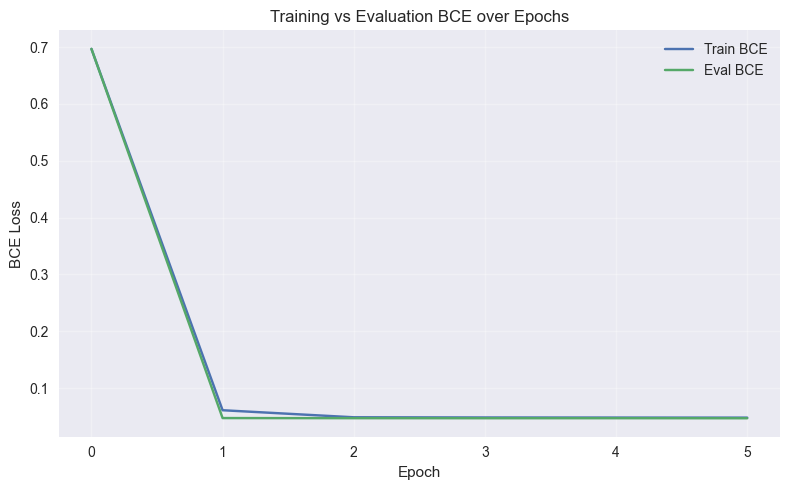

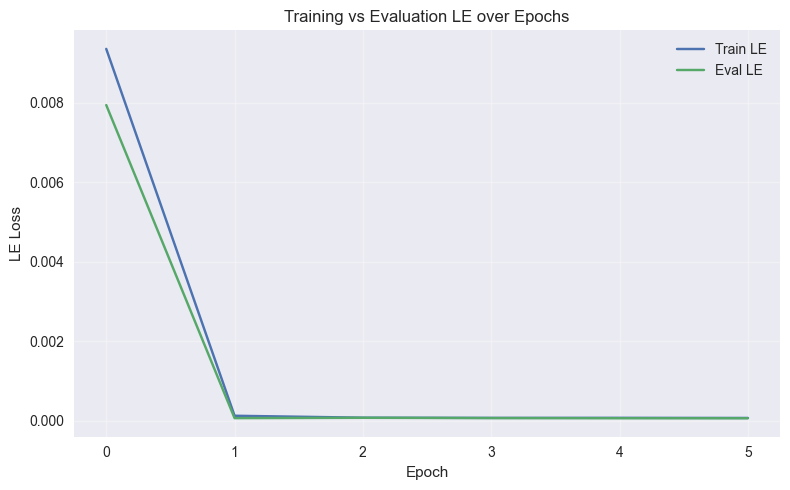

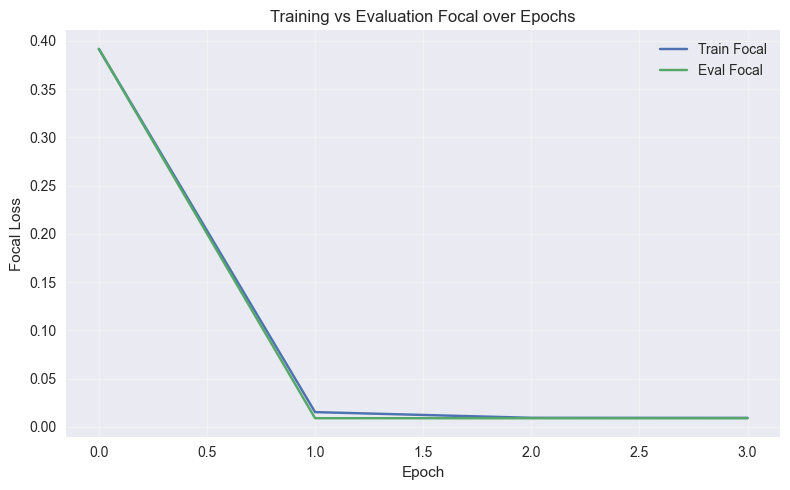

In [8]:
"""Plot training/eval loss curves."""
if plots_cfg.get('loss_curves', True):
    for loss_mode, result in run_results.items():
        output_path = output_paths[loss_mode]["loss_curves"]
        plot_loss_curves(
            result.train_losses,
            result.eval_losses,
            result.loss_label,
            output_path=output_path,
            eval_batch_losses=result.eval_batch_losses if eval_every_n_batches > 0 else None,
        )


=== BCE model evaluation ===
Eval (BCE) prediction summary:
  n=1,200,000 mean=0.012014 std=0.035182
  min=0.000000 p01=0.000002 p05=0.000011 p50=0.002222 p95=0.052567 p99=0.148930 max=0.786632
  label base_rate=0.011518 | logloss=0.046981 | brier=0.010299 | acc@0.5=0.988704
  Top 8 conditions by count:
       count  pred_mean  label_mean
cond                               
0     300369   0.027787    0.026238
2     300171   0.006402    0.006560
1     299935   0.013662    0.012969
3     299525   0.000170    0.000274


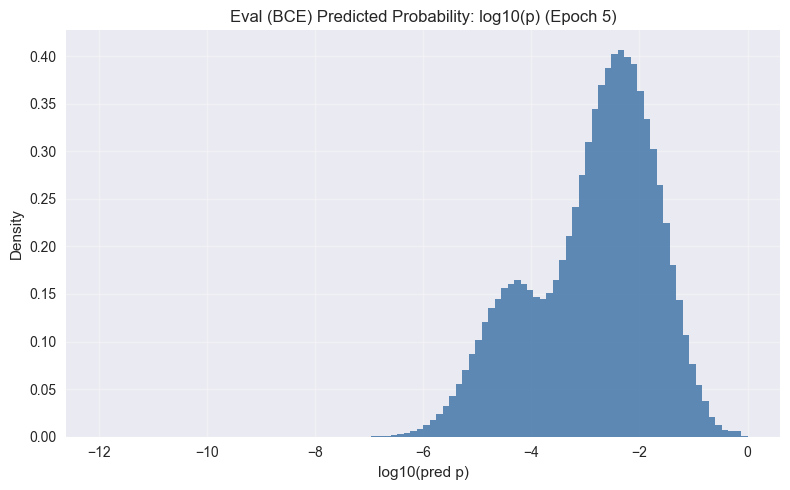

Eval (BCE) predictions per condition: [300369, 299935, 300171, 299525]


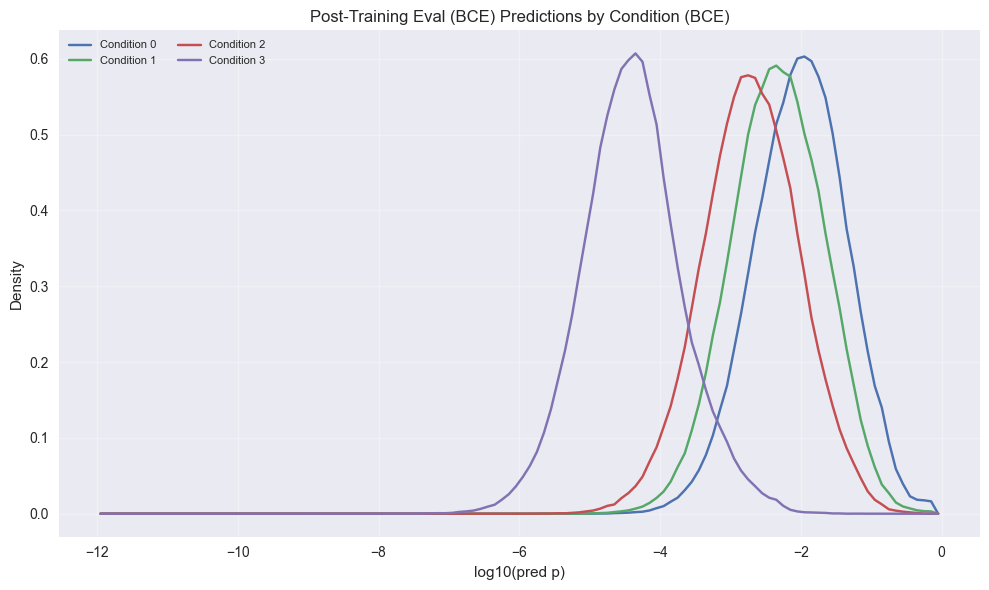

DEBUG: PREDICTIONS ARRAY
[0.0343 0.0005 0.0048 0.0001 0.0069 0.0006 0.     0.0054 0.0058 0.0107
 0.0001 0.0375 0.1096 0.     0.0027 0.0357 0.0609 0.0182 0.0025 0.0072
 0.0057 0.0027 0.003  0.0025 0.1771 0.     0.     0.0065 0.0001 0.
 0.0241 0.0038 0.0183 0.0062 0.0056 0.0001 0.0434 0.0072 0.0018 0.
 0.0036 0.0029 0.0563 0.009  0.0002 0.0065 0.0071 0.0024 0.0014 0.0041
 0.0088 0.0002 0.0023 0.0007 0.0052 0.     0.0001 0.0034 0.0006 0.0052
 0.003  0.0022 0.0003 0.0003 0.0179 0.0028 0.0047 0.0001 0.0026 0.0004
 0.0222 0.0308 0.0007 0.0189 0.     0.0207 0.0258 0.0004 0.0162 0.0063
 0.0069 0.0495 0.     0.0045 0.     0.0013 0.0109 0.0065 0.0321 0.0221
 0.0072 0.0021 0.0036 0.0121 0.     0.0021 0.0001 0.0014 0.     0.0373]
Final Eval BCE: 0.0469811943
BCE Total BCE (log loss): 0.04698119
BCE Total ECE: 0.00054711
BCE Total ECE (small p<= 0.01): 0.00025416
BCE Total ROC-AUC: 0.89054594
BCE Total PR-AUC (AP): 0.18093172
BCE Total Accuracy@0.5: 0.98870417
BCE Total F1@0.5: 0.09915598
 conditio

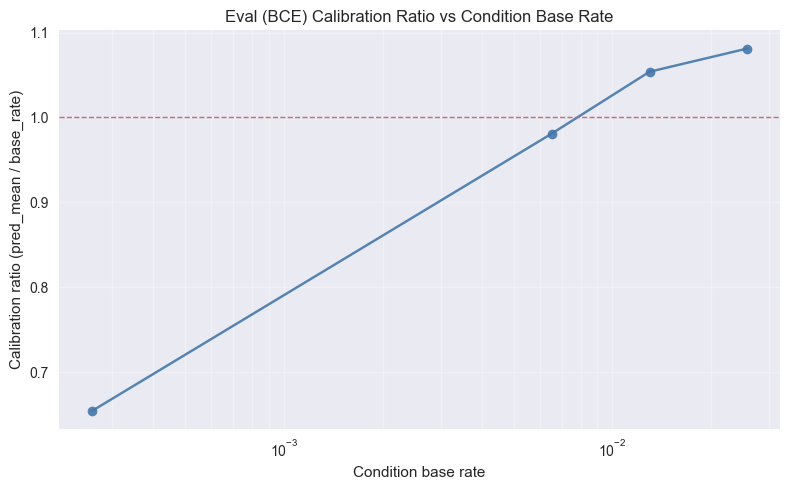

 Condition  train_clicks  train_total  train_click_rate  eval_pred_avg  eval_total  pred_to_train_rate
         3           705      2700475          0.000261       0.000170      299525            0.651779
         1         35115      2700065          0.013005       0.013662      299935            1.050490
         2         17564      2699829          0.006506       0.006402      300171            0.984022
         0         69855      2699631          0.025876       0.027787      300369            1.073878


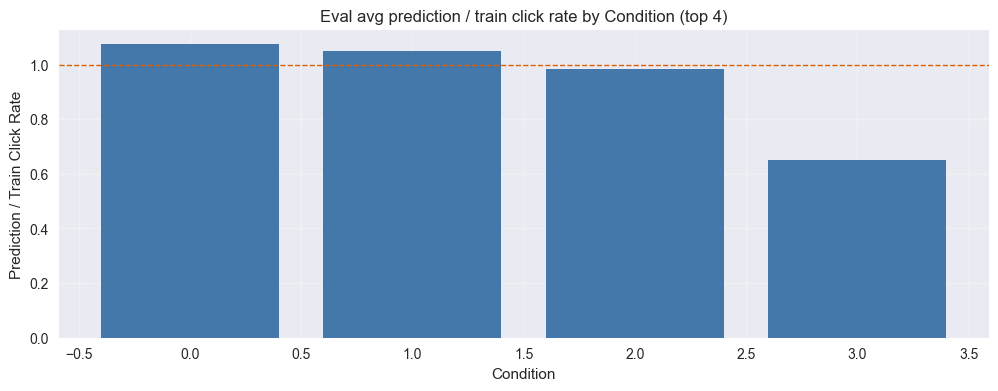

=== LE model evaluation ===
Eval (LE) prediction summary:
  n=1,200,000 mean=0.010572 std=0.022530
  min=0.000000 p01=0.000005 p05=0.000021 p50=0.003390 p95=0.046443 p99=0.133392 max=0.133393
  label base_rate=0.011518 | logloss=0.048292 | brier=0.010678 | acc@0.5=0.988482
  Top 8 conditions by count:
       count  pred_mean  label_mean
cond                               
0     300369   0.022997    0.026238
2     300171   0.006555    0.006560
1     299935   0.012467    0.012969
3     299525   0.000238    0.000274


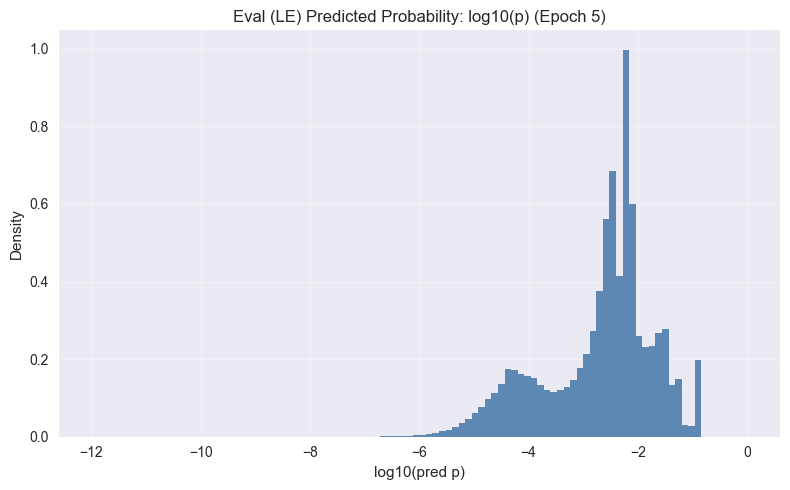

Eval (LE) predictions per condition: [300369, 299935, 300171, 299525]


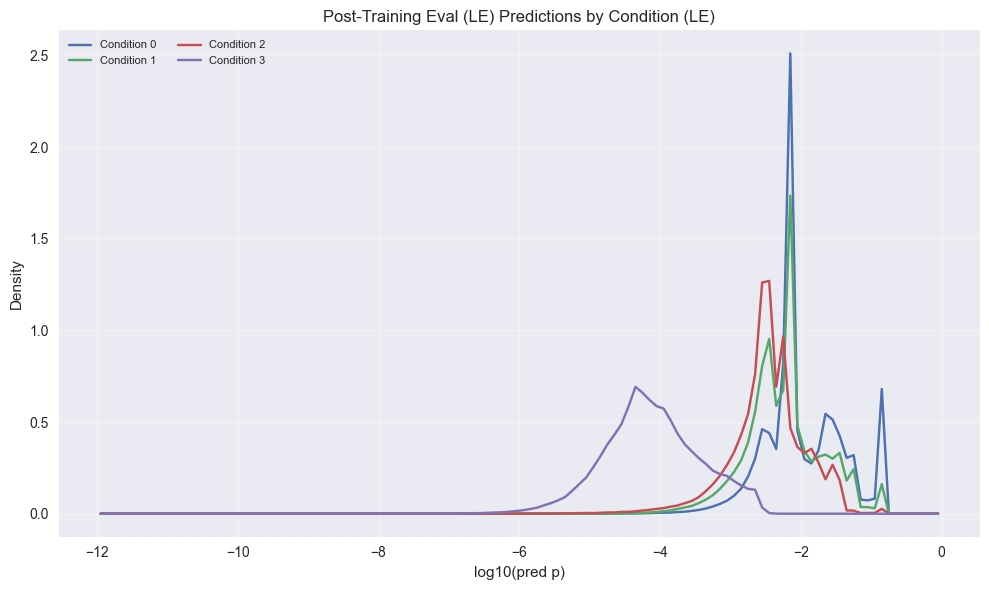

DEBUG: PREDICTIONS ARRAY
[0.0248 0.0018 0.0061 0.0001 0.0069 0.001  0.     0.0063 0.0063 0.0141
 0.0002 0.0335 0.1334 0.     0.0038 0.0261 0.0331 0.0185 0.0034 0.0063
 0.006  0.0055 0.0023 0.0036 0.1334 0.     0.     0.0071 0.0002 0.
 0.026  0.0055 0.0186 0.0068 0.0062 0.0002 0.034  0.0068 0.0019 0.0001
 0.0056 0.0039 0.0519 0.0118 0.0006 0.0068 0.0063 0.003  0.003  0.0057
 0.0089 0.0004 0.0036 0.0022 0.0068 0.     0.0002 0.0048 0.0021 0.0071
 0.0047 0.0046 0.0007 0.0003 0.012  0.0034 0.0069 0.0002 0.0046 0.0006
 0.0229 0.0287 0.0017 0.0213 0.     0.0188 0.0234 0.0011 0.0085 0.0073
 0.0073 0.0359 0.     0.0051 0.     0.0024 0.0132 0.0072 0.0327 0.024
 0.0058 0.0034 0.0056 0.0112 0.     0.0031 0.0001 0.0022 0.     0.0307]
Final Eval LE: 0.0000682608
LE Total BCE (log loss): 0.04829206
LE Total ECE: 0.00094669
LE Total ECE (small p<= 0.01): 0.00010892
LE Total ROC-AUC: 0.88806452
LE Total PR-AUC (AP): 0.11795201
LE Total Accuracy@0.5: 0.98848167
LE Total F1@0.5: 0.00000000
 condition  co

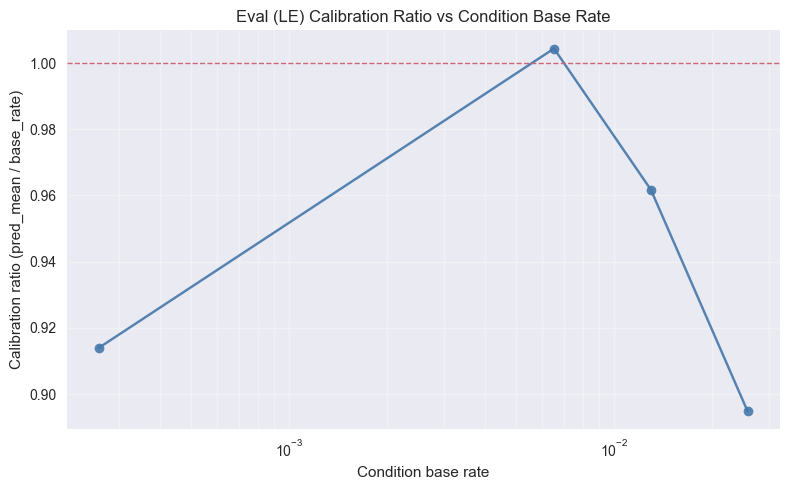

 Condition  train_clicks  train_total  train_click_rate  eval_pred_avg  eval_total  pred_to_train_rate
         3           705      2700475          0.000261       0.000238      299525            0.910988
         1         35115      2700065          0.013005       0.012467      299935            0.958639
         2         17564      2699829          0.006506       0.006555      300171            1.007643
         0         69855      2699631          0.025876       0.022997      300369            0.888753


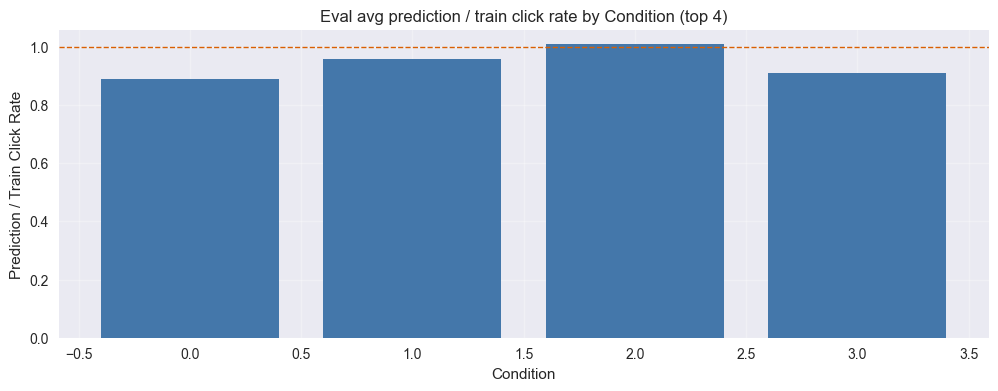

=== Focal model evaluation ===
Eval (Focal) prediction summary:
  n=1,200,000 mean=0.011283 std=0.021137
  min=0.000000 p01=0.000043 p05=0.000118 p50=0.004712 p95=0.043296 p99=0.100445 max=0.368198
  label base_rate=0.011518 | logloss=0.047728 | brier=0.010482 | acc@0.5=0.988482
  Top 8 conditions by count:
       count  pred_mean  label_mean
cond                               
0     300369   0.023558    0.026238
2     300171   0.007747    0.006560
1     299935   0.013289    0.012969
3     299525   0.000508    0.000274


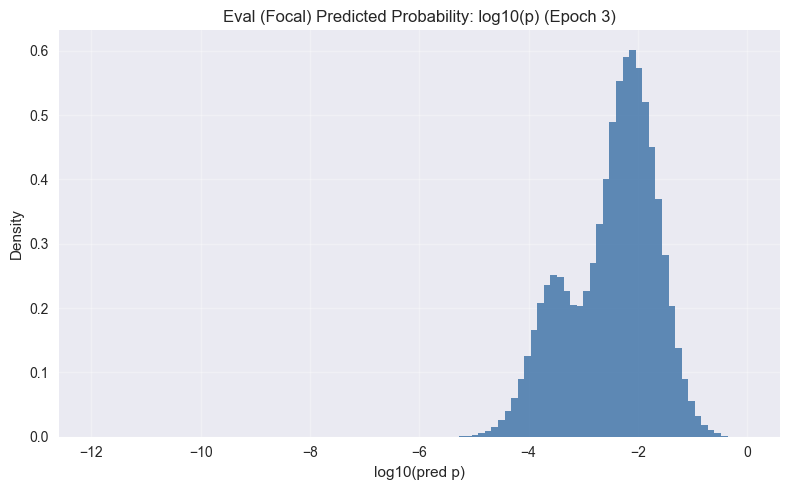

Eval (Focal) predictions per condition: [300369, 299935, 300171, 299525]


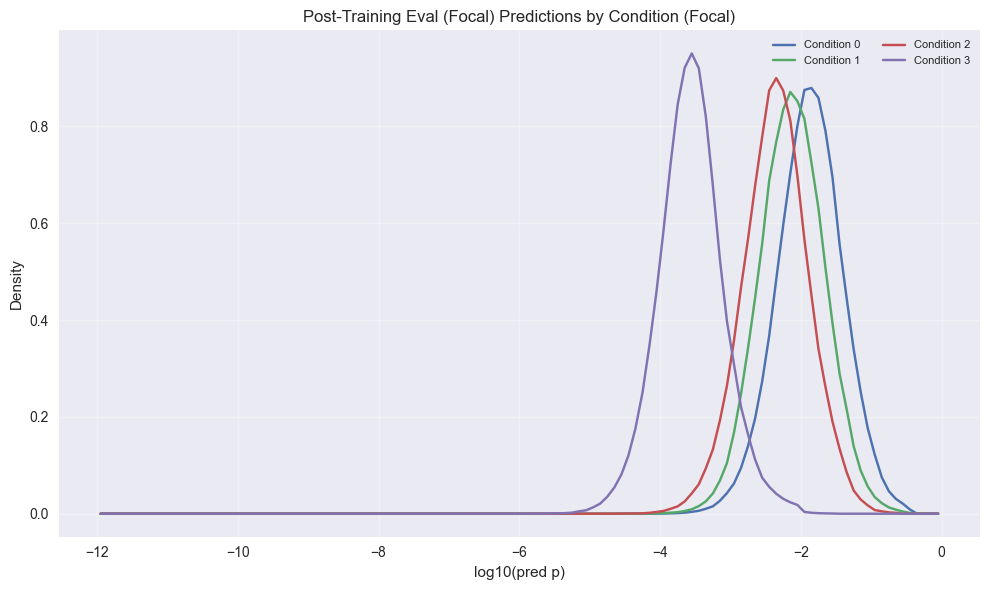

DEBUG: PREDICTIONS ARRAY
[0.0354 0.0017 0.0087 0.0004 0.0101 0.0016 0.0001 0.0105 0.0092 0.0136
 0.0004 0.0314 0.0834 0.     0.0056 0.0339 0.0483 0.0189 0.0048 0.0091
 0.0098 0.0057 0.0054 0.0045 0.1125 0.0002 0.0001 0.0091 0.0004 0.0002
 0.0227 0.007  0.0187 0.0092 0.0082 0.0005 0.0386 0.0104 0.0031 0.0003
 0.0068 0.0052 0.0461 0.0119 0.0006 0.0097 0.0124 0.0044 0.0036 0.007
 0.0121 0.0007 0.0048 0.0022 0.0082 0.0001 0.0005 0.0071 0.0021 0.0078
 0.0059 0.0048 0.0012 0.001  0.0214 0.0045 0.0073 0.0004 0.005  0.0012
 0.0216 0.0296 0.0026 0.0186 0.0001 0.022  0.0259 0.0016 0.0207 0.0093
 0.0095 0.0435 0.     0.0072 0.0001 0.003  0.0136 0.0092 0.0282 0.0198
 0.0123 0.0049 0.0082 0.0136 0.0002 0.004  0.0003 0.0031 0.     0.0339]
Final Eval Focal: 0.0088071931
Focal Total BCE (log loss): 0.04772841
Focal Total ECE: 0.00274771
Focal Total ECE (small p<= 0.01): 0.00125480
Focal Total ROC-AUC: 0.89040244
Focal Total PR-AUC (AP): 0.18165244
Focal Total Accuracy@0.5: 0.98848167
Focal Total F1@0.

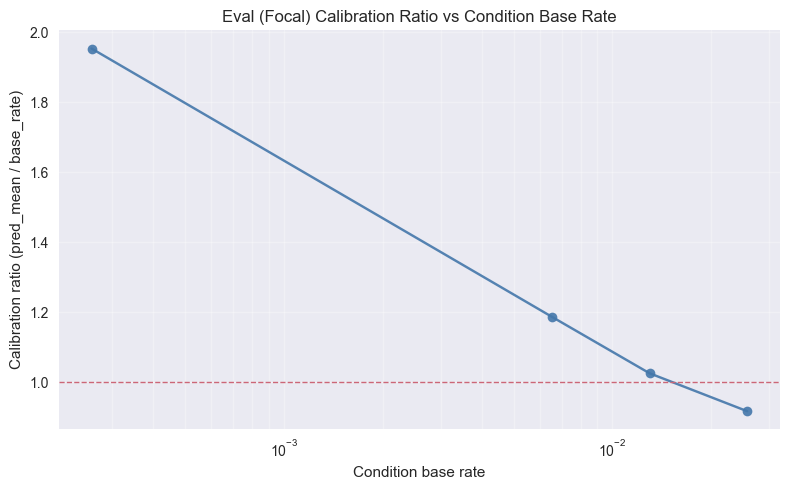

 Condition  train_clicks  train_total  train_click_rate  eval_pred_avg  eval_total  pred_to_train_rate
         3           705      2700475          0.000261       0.000508      299525            1.946746
         1         35115      2700065          0.013005       0.013289      299935            1.021849
         2         17564      2699829          0.006506       0.007747      300171            1.190842
         0         69855      2699631          0.025876       0.023558      300369            0.910440


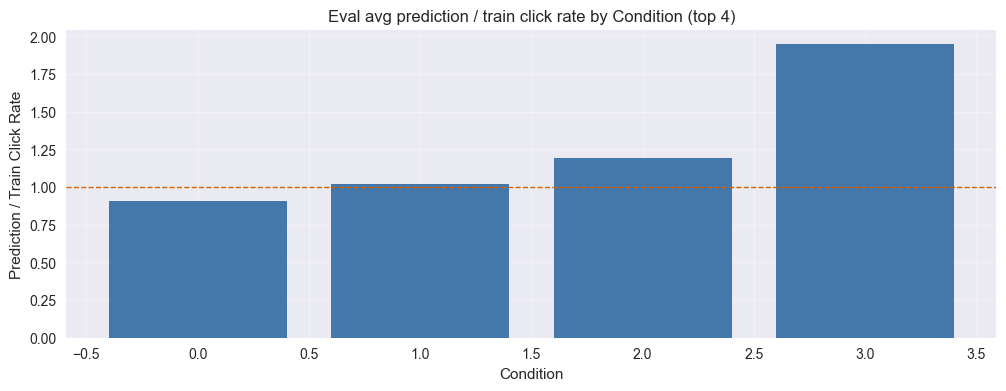

In [9]:
"""Evaluate trained models, compute metrics, and render plots."""
eval_cfg = cfg.get('evaluation', {})
for loss_mode, result in run_results.items():
    label = result.loss_label
    eval_preds = result.eval_preds
    eval_loss = result.eval_loss
    model = result.model
    loss_train_cfg = loss_train_cfgs.get(loss_mode, train_cfg)
    epochs_completed = max(0, len(result.train_losses) - 1)
    display_name = eval_name if not train_multi else f"{eval_name} ({label})"
    print(f"=== {label} model evaluation ===")
    # Summary + plots
    if plots_cfg.get('print_eval_summary', True):
        print_pred_summary(display_name, eval_preds, labels=eval_labels, conds=eval_conds)
    if plots_cfg.get('eval_pred_hist', True):
        plot_eval_log10p_hist(eval_preds.astype(np.float32), epoch=epochs_completed, name=display_name)
    if plots_cfg.get('eval_pred_by_condition', True):
        if eval_conds is None:
            print(f"{display_name} conditions unavailable; skipping eval predictions by condition.")
        else:
            plot_eval_predictions_by_condition(
                eval_preds,
                eval_conds,
                splits.num_conditions,
                value_range=eval_value_range,
                name=display_name,
                output_path=output_paths[loss_mode]["post_training_eval_predictions"],
                title=(
                    f"Post-Training {display_name} Predictions by {condition_label} ("
                    f"{label})"
                ),
            )
            print("DEBUG: PREDICTIONS ARRAY")
            print(eval_preds[:100])
    # Metrics that require labels
    if eval_has_labels:
        print(f"Final {eval_name} {label}: {eval_loss:.10f}")
    else:
        print(f"Final {eval_name} {label}: n/a (labels unavailable)")
    if eval_has_labels:
        bins = int(eval_cfg.get('ece_bins', 20))
        min_count = int(eval_cfg.get('ece_min_count', 1))
        small_prob_max_cfg = float(eval_cfg.get('small_prob_max', 0.01))
        small_prob_quantile = float(eval_cfg.get('small_prob_quantile', 0.1))
        total_bce = bce_log_loss(eval_preds, eval_labels)
        total_ece, total_ece_table = expected_calibration_error(
            eval_preds, eval_labels, bins=bins, min_count=min_count
        )
        # Define low-probability calibration subset; fall back to a quantile if needed.
        small_threshold = small_prob_max_cfg
        small_mask = eval_preds <= small_threshold
        if not small_mask.any():
            quantile_threshold = float(np.quantile(eval_preds, small_prob_quantile))
            print(
                f"[INFO] No preds <= {small_threshold:g}; using {small_prob_quantile:.2f} quantile "
                f"threshold {quantile_threshold:g} for small-prob calibration."
            )
            small_threshold = quantile_threshold
            small_mask = eval_preds <= small_threshold
        if small_mask.any():
            total_ece_small, _ = expected_calibration_error(
                eval_preds[small_mask],
                eval_labels[small_mask],
                bins=bins,
                min_count=min_count,
            )
        else:
            total_ece_small = float('nan')
        print(f"{label} Total BCE (log loss): {total_bce:.8f}")
        print(f"{label} Total ECE: {total_ece:.8f}")
        print(f"{label} Total ECE (small p<= {small_threshold:g}): {total_ece_small:.8f}")
        total_auc = roc_auc_score(eval_preds, eval_labels)
        total_pr_auc = pr_auc_score(eval_preds, eval_labels)
        print(f"{label} Total ROC-AUC: {total_auc:.8f}")
        print(f"{label} Total PR-AUC (AP): {total_pr_auc:.8f}")
        cls_metrics = binary_classification_metrics(eval_preds, eval_labels)
        print(f"{label} Total Accuracy@0.5: {cls_metrics['accuracy']:.8f}")
        print(f"{label} Total F1@0.5: {cls_metrics['f1']:.8f}")
        if eval_cfg.get('print_calibration_table', False):
            print(total_ece_table.to_string(index=False))
        if eval_conds is None:
            print(f"[WARN] {display_name} conditions unavailable; skipping per-condition metrics.")
        else:
            per_ad = per_condition_metrics(
                eval_preds,
                eval_labels,
                eval_conds,
                bins=bins,
                min_count=min_count,
                small_prob_max=small_threshold,
            )
            if eval_cfg.get('print_per_ad', True):
                top_k = int(eval_cfg.get('per_ad_top_k', 10))
                print(per_ad.head(top_k).to_string(index=False))
        if plots_cfg.get('eval_calibration_ratio', True):
            if eval_conds is None:
                print(f"[WARN] {display_name} conditions unavailable; skipping calibration ratio plot.")
            else:
                cal_df = None
                if use_true_le_base_rates and le_base_rates_eval is not None:
                    cal_df = per_condition_calibration_from_base_rates(
                        eval_preds,
                        eval_conds,
                        le_base_rates_eval,
                    )
                elif eval_has_labels:
                    cal_df = per_condition_calibration(
                        eval_preds,
                        eval_labels,
                        eval_conds,
                    )
                if cal_df is None:
                    print(f"[WARN] {display_name} calibration data unavailable; skipping calibration ratio plot.")
                else:
                    plot_calibration_ratio_by_condition(
                        cal_df['base_rate'].to_numpy(),
                        cal_df['calibration'].to_numpy(),
                        name=display_name,
                        condition_label=condition_label,
                        title=f"{display_name} Calibration Ratio vs {condition_label} Base Rate",
                        output_path=output_paths[loss_mode]['calibration_ratio'],
                    )
        if not train_multi:
            focal_cfg = loss_train_cfg.get('focal', {}) if isinstance(loss_train_cfg, dict) else {}
            focal_alpha = focal_cfg.get('alpha') if isinstance(focal_cfg, dict) else None
            focal_gamma = focal_cfg.get('gamma') if isinstance(focal_cfg, dict) else None
            for mode in loss_train_cfg.get('eval_compare_losses', []):
                if mode == loss_mode:
                    continue
                other_base_rates = (
                    le_base_rates_eval if (use_true_le_base_rates and mode == 'localized_entropy') else None
                )
                other_loss, _ = evaluate(
                    model,
                    eval_loader,
                    device,
                    loss_mode=mode,
                    focal_alpha=focal_alpha,
                    focal_gamma=focal_gamma,
                    base_rates=other_base_rates,
                    non_blocking=non_blocking,
                )
                other_label = loss_label(mode)
                print(f"Final {eval_name} {other_label}: {other_loss:.10f}")
    # Per-ad train click rates vs. eval prediction averages
    plot_df = summarize_per_ad_train_eval_rates(
        splits.y_train,
        splits.c_train,
        eval_preds,
        eval_conds,
        splits.num_conditions,
        condition_label=condition_label,
        eval_name=eval_name,
        top_k=eval_cfg.get('per_ad_top_k', 10),
    )
    if plot_df is not None:
        plot_pred_to_train_rate(
            plot_df,
            condition_label=condition_label,
            eval_name=eval_name,
            output_path=output_paths[loss_mode]["pred_to_train_rate"],
        )


In [10]:
"""Run optional test-set inference/plots when configured."""
if loaders.test_loader is not None and eval_split != 'test':
    for loss_mode, result in run_results.items():
        label = result.loss_label
        display_name = 'Test' if not train_multi else f"Test ({label})"
        test_preds = predict_probs(
            result.model,
            loaders.test_loader,
            device,
            non_blocking=non_blocking,
        )
        if test_preds.size > 0:
            print_pred_summary(display_name, test_preds, labels=None, conds=splits.c_test)
            if plots_cfg.get('eval_pred_hist', True):
                plot_eval_log10p_hist(
                    test_preds.astype(np.float32),
                    epoch=train_cfg['epochs'],
                    name=display_name,
                )
            if plots_cfg.get('eval_pred_by_condition', True):
                if splits.c_test is None:
                    print(f"{display_name} conditions unavailable; skipping test predictions by condition.")
                else:
                    plot_eval_predictions_by_condition(
                        test_preds,
                        splits.c_test,
                        splits.num_conditions,
                        value_range=eval_value_range,
                        name=display_name,
                        title=(
                            f"Post-Training {display_name} Predictions by {condition_label} ("
                            f"{label})"
                        ),
                    )
        else:
            print(f"{display_name} set is empty after filtering; skipping test plot.")


LE stats table (BCE)
cond	num	den	avg_p	#y=1	#y=0	ratio
0	28663	36467.9	0.0262377	7881	292488	0.785979
1	17030.3	20767.3	0.0129695	3890	296045	0.820055
2	9993.18	11860.3	0.00655959	1969	298202	0.842571
3	690.878	754.654	0.000273767	82	299443	0.915489


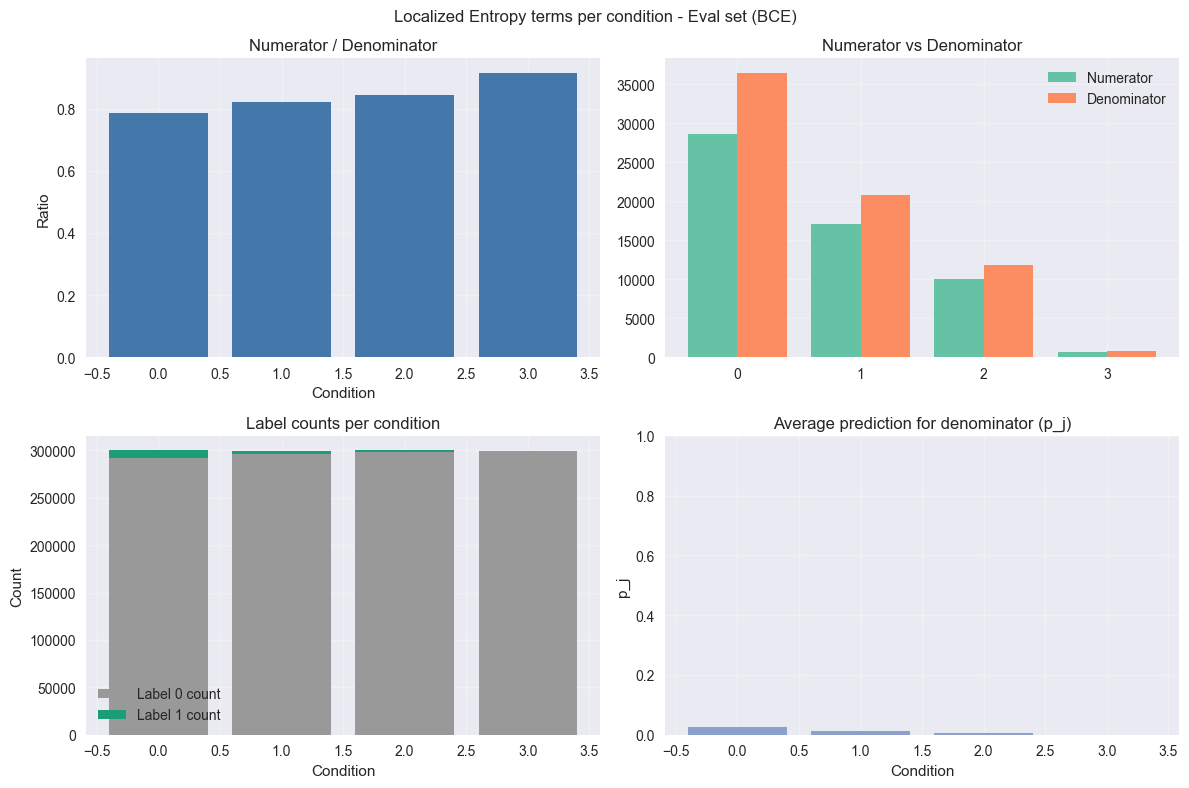

LE stats table (LE)
cond	num	den	avg_p	#y=1	#y=0	ratio
0	29902	36467.9	0.0262377	7881	292488	0.819953
1	17248.2	20767.3	0.0129695	3890	296045	0.830547
2	10115.8	11860.3	0.00655959	1969	298202	0.852908
3	684.459	754.654	0.000273767	82	299443	0.906984


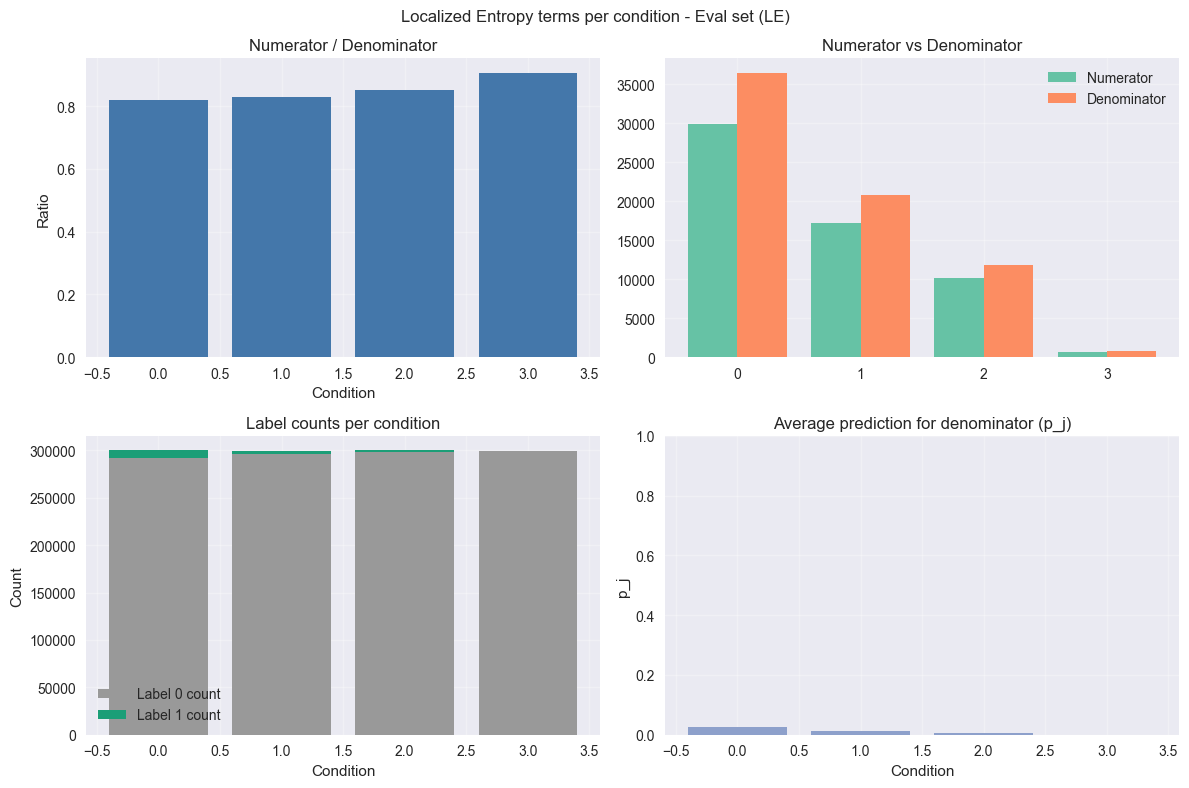

LE stats table (Focal)
cond	num	den	avg_p	#y=1	#y=0	ratio
0	29265.2	36467.9	0.0262377	7881	292488	0.802491
1	17208.7	20767.3	0.0129695	3890	296045	0.828645
2	10102.7	11860.3	0.00655959	1969	298202	0.851806
3	697.459	754.654	0.000273767	82	299443	0.92421


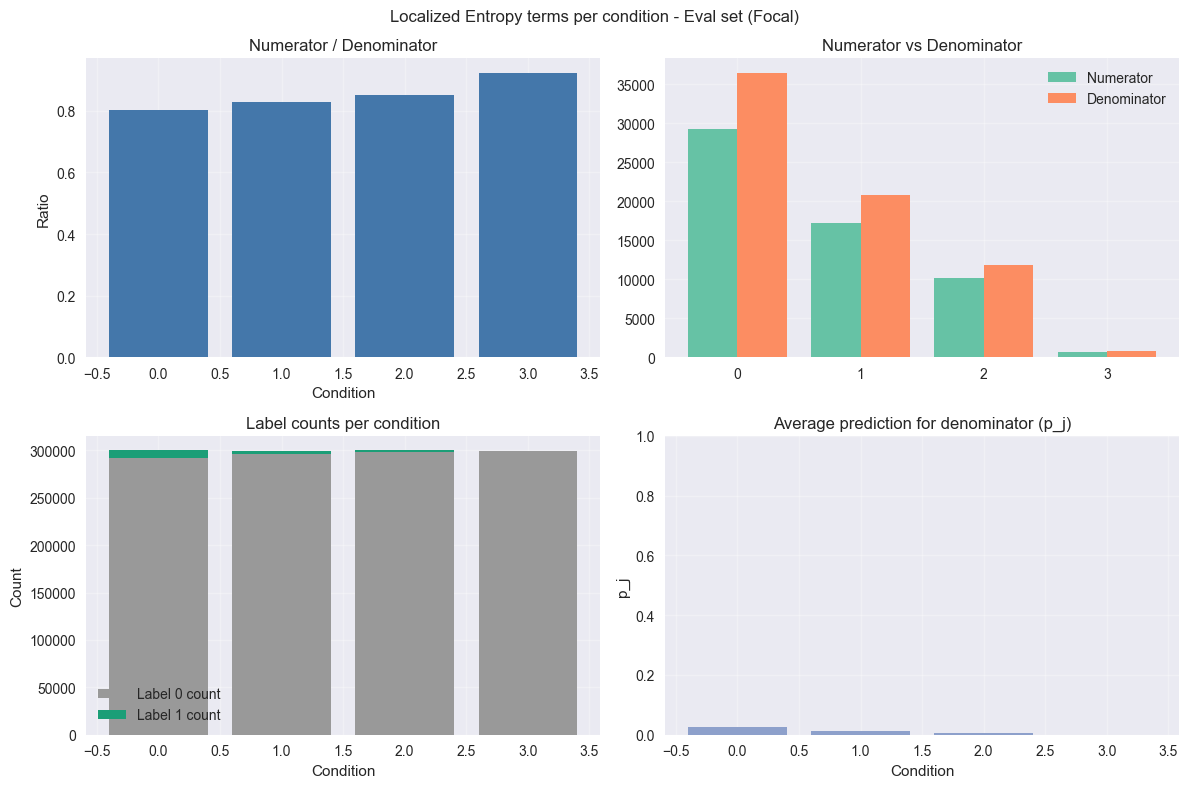

In [11]:
"""Compute localized entropy stats per condition and plot tables."""
need_le_stats = (
    plots_cfg.get('le_stats', True)
    or plots_cfg.get('print_le_stats_table', True)
    or train_bce_le
)
if need_le_stats:
    if not eval_has_labels:
        print(f"{eval_name} labels unavailable; skipping localized entropy stats.")
    elif eval_conds is None:
        print(f"{eval_name} conditions unavailable; skipping localized entropy stats.")
    else:
        for loss_mode, result in run_results.items():
            label = result.loss_label
            z_all = result.eval_logits
            y_all = result.eval_targets
            c_all = result.eval_conds
            if z_all is None or y_all is None or c_all is None:
                z_all, y_all, c_all = collect_logits(
                    result.model, eval_loader, device, non_blocking=non_blocking
                )
                result.eval_logits = z_all
                result.eval_targets = y_all
                result.eval_conds = c_all
            le_stats = collect_le_stats_per_condition(z_all, y_all, c_all, eps=1e-12)
            if plots_cfg.get('print_le_stats_table', True):
                print(f"LE stats table ({label})")
                print('cond	num	den	avg_p	#y=1	#y=0	ratio')
                for cond in sorted(le_stats.keys()):
                    s = le_stats[cond]
                    print(
                        f"{cond}	{s['Numerator']:.6g}	{s['Denominator']:.6g}	"
                        f"{s['Average prediction for denominator']:.6g}	"
                        f"{s['Number of samples with label 1']}	"
                        f"{s['Number of samples with label 0']}	"
                        f"{s['Numerator/denominator']:.6g}"
                    )
            if plots_cfg.get('le_stats', True):
                plot_le_stats_per_condition(
                    le_stats,
                    title=f"Localized Entropy terms per condition - {eval_name} set ({label})",
                )


Eval: per-Condition BCE vs LE comparison
Condition  count   base_rate    bce_pred_mean  le_pred_mean  bce_logloss  le_logloss  bce_calibration  le_calibration  delta_calibration  bce_le_ratio  le_le_ratio  delta_le_ratio
        0  300369    0.0262377      0.0277874     0.0229972    0.0954261   0.0995508          1.05906        0.876492          -0.182571      0.785979     0.819953       0.0339737
        1  299935    0.0129695      0.0136619     0.0124673    0.0567801   0.0575066          1.05339        0.961282         -0.0921045      0.820055     0.830547       0.0104928
        2  300171   0.00655959     0.00640165    0.00655532    0.0332916   0.0337001         0.975921        0.999349          0.0234275      0.842571     0.852908        0.010337
        3  299525  0.000273767    0.000170157   0.000237827   0.00230658  0.00228515         0.621539        0.868722           0.247183      0.915489     0.906984     -0.00850549

Eval: per-Condition abs(1 - calibration) (lower is better)

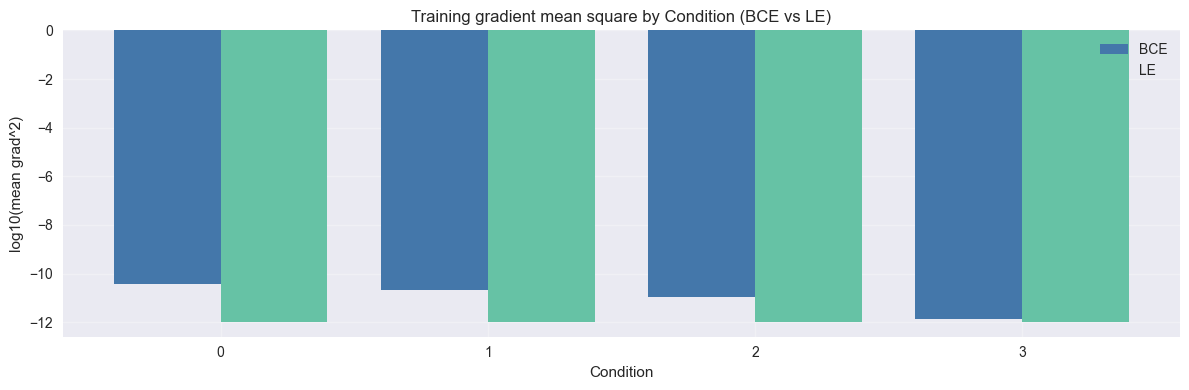

Training per-Condition grad MSE ratio (LE/BCE)
Condition  bce_grad_mse  le_grad_mse  le_over_bce_grad_mse
        0      3.73e-11  4.32448e-18           1.15938e-07
        1   2.04343e-11  6.74436e-18           3.30052e-07
        2   1.09838e-11  1.07997e-17           9.83239e-07
        3   1.37937e-12  1.38397e-16           0.000100334

BCE grad MSE by class: 0=2.348515e-12 (n=53383805), 1=1.332167e-09 (n=616195), ratio=0.0018
LE grad MSE by class: 0=1.954638e-17 (n=53383805), 1=1.818326e-15 (n=616195), ratio=0.0107


In [12]:
"""Compare BCE vs LE and plot gradient diagnostics if enabled."""
compare_cfg = cfg.get('comparison', {})
compare_enabled = compare_cfg.get('enabled', True)
has_bce = 'bce' in run_results
has_le = 'localized_entropy' in run_results
has_focal = 'focal' in run_results
if train_bce_le and compare_enabled:
    if not eval_has_labels or eval_conds is None:
        print(f"[WARN] {eval_name} labels/conditions unavailable; skipping BCE vs LE comparison.")
    else:
        bce_result = run_results.get('bce')
        le_result = run_results.get('localized_entropy')
        if bce_result is None or le_result is None:
            print("[WARN] Missing BCE or LE results; skipping comparison.")
        else:
            comparison = compare_bce_le_runs(
                bce_result,
                le_result,
                eval_labels,
                eval_conds,
                condition_label=condition_label,
                sort_by=str(compare_cfg.get('sort_by', 'count')),
            )
            comparison_table = comparison.sort_values(condition_label)
            if compare_cfg.get('print_table', True):
                table_columns = [
                    condition_label,
                    'count',
                    'base_rate',
                    'bce_pred_mean',
                    'le_pred_mean',
                    'bce_logloss',
                    'le_logloss',
                    'bce_calibration',
                    'le_calibration',
                    'delta_calibration',
                    'bce_le_ratio',
                    'le_le_ratio',
                    'delta_le_ratio',
                ]
                title = f"{eval_name}: per-{condition_label} BCE vs LE comparison"
                print(title)
                print(format_comparison_table(
                    comparison_table,
                    table_columns,
                    top_k=int(compare_cfg.get('top_k', 20)),
                ))
                print('')
                cal_table = comparison_table[[condition_label, 'bce_calibration', 'le_calibration']].copy()
                if has_focal:
                    focal_result = run_results.get('focal')
                    if focal_result is not None:
                        focal_cal = per_condition_calibration(
                            focal_result.eval_preds,
                            eval_labels,
                            eval_conds,
                        )
                        focal_cal = focal_cal.rename(
                            columns={'calibration': 'fl_calibration'}
                        )
                        cal_table = cal_table.merge(
                            focal_cal[["condition", 'fl_calibration']],
                            left_on=condition_label,
                            right_on='condition',
                            how='left',
                        ).drop(columns=['condition'])
                cal_table['bce_abs_1_minus_cal'] = (1.0 - cal_table['bce_calibration']).abs()
                cal_table['le_abs_1_minus_cal'] = (1.0 - cal_table['le_calibration']).abs()
                if 'fl_calibration' in cal_table.columns:
                    cal_table['fl_abs_1_minus_cal'] = (1.0 - cal_table['fl_calibration']).abs()
                cal_title = (
                    f"{eval_name}: per-{condition_label} abs(1 - calibration) (lower is better)"
                )
                print(cal_title)
                print(format_comparison_table(
                    cal_table.sort_values(condition_label),
                    [
                        condition_label,
                        'bce_abs_1_minus_cal',
                        'le_abs_1_minus_cal',
                        *(['fl_abs_1_minus_cal'] if 'fl_abs_1_minus_cal' in cal_table.columns else []),
                    ],
                    top_k=int(compare_cfg.get('top_k', 20)),
                ))
                print('')
                eval_cfg = cfg.get('evaluation', {})
                print(format_bce_le_summary(
                    bce_result,
                    le_result,
                    eval_labels,
                    eval_conds=eval_conds,
                    condition_label=condition_label,
                    ece_bins=int(eval_cfg.get('ece_bins', 20)),
                    ece_min_count=int(eval_cfg.get('ece_min_count', 1)),
                    small_prob_max=float(eval_cfg.get('small_prob_max', 0.01)),
                    small_prob_quantile=float(eval_cfg.get('small_prob_quantile', 0.1)),
                ))
if compare_enabled and has_focal:
    if not eval_has_labels:
        print(f"[WARN] {eval_name} labels unavailable; skipping focal comparison metrics.")
    else:
        eval_cfg = cfg.get('evaluation', {})
        loss_order = [
            ('bce', 'BCE'),
            ('localized_entropy', 'LE'),
            ('focal', 'Focal'),
        ]
        metrics_rows = []
        for key, name in loss_order:
            result = run_results.get(key)
            if result is None:
                continue
            metrics = summarize_model_metrics(
                result.eval_preds,
                eval_labels,
                ece_bins=int(eval_cfg.get('ece_bins', 20)),
                ece_min_count=int(eval_cfg.get('ece_min_count', 1)),
                threshold=0.5,
                small_prob_max=float(eval_cfg.get('small_prob_max', 0.01)),
                small_prob_quantile=float(eval_cfg.get('small_prob_quantile', 0.1)),
            )
            metrics_rows.append((name, metrics))
        if metrics_rows:
            columns = ['metric'] + [name for name, _ in metrics_rows]
            metrics_frame = pd.DataFrame(
                {
                    'metric': ['accuracy@0.5', 'logloss', 'brier', 'ece', 'ece_small'],
                    **{
                        name: [
                            metrics['accuracy'],
                            metrics['logloss'],
                            metrics['brier'],
                            metrics['ece'],
                            metrics['ece_small'],
                        ]
                        for name, metrics in metrics_rows
                    },
                }
            )
            title = "BCE vs LE vs Focal summary (lower is better for logloss/brier/ece):"
            print(title)
            print(format_comparison_table(metrics_frame, columns, top_k=len(metrics_frame)))

grad_plot_enabled = plots_cfg.get('grad_sq_by_condition', False)
if grad_plot_enabled:
    if not train_bce_le:
        print('[WARN] Grad plot requires BCE and LE runs; skipping.')
    else:
        bce_result = run_results.get('bce')
        le_result = run_results.get('localized_entropy')
        if bce_result is None or le_result is None:
            print('[WARN] Missing BCE or LE results; skipping grad plot.')
        else:
            bce_grad_stats = bce_result.grad_sq_stats
            le_grad_stats = le_result.grad_sq_stats
            if bce_grad_stats is None or le_grad_stats is None:
                print('[WARN] Grad stats not collected; enable plots.grad_sq_by_condition to track.')
            else:
                bce_grads = bce_grad_stats.mean_by_condition
                le_grads = le_grad_stats.mean_by_condition
                plot_grad_sq_sums_by_condition(
                    bce_grads,
                    le_grads,
                    condition_label=condition_label,
                    title=(
                        f"Training gradient mean square by {condition_label} (BCE vs LE)"
                    ),
                    top_k=int(plots_cfg.get('grad_sq_top_k', 0) or 0),
                    log10=bool(plots_cfg.get('grad_sq_log10', True)),
                )

                grad_cond_ids = np.arange(len(bce_grad_stats.mean_by_condition))
                grad_top_k = int(plots_cfg.get('grad_sq_top_k', 0) or 0)
                if grad_top_k > 0 and grad_top_k < grad_cond_ids.size:
                    scores = np.maximum(
                        bce_grad_stats.mean_by_condition,
                        le_grad_stats.mean_by_condition,
                    )
                    grad_cond_ids = np.argsort(scores)[::-1][:grad_top_k]
                bce_vals = bce_grad_stats.mean_by_condition[grad_cond_ids]
                le_vals = le_grad_stats.mean_by_condition[grad_cond_ids]
                ratio = np.divide(
                    le_vals,
                    bce_vals,
                    out=np.full_like(le_vals, np.nan),
                    where=bce_vals != 0,
                )
                grad_table = pd.DataFrame(
                    {
                        condition_label: grad_cond_ids,
                        'bce_grad_mse': bce_vals,
                        'le_grad_mse': le_vals,
                        'le_over_bce_grad_mse': ratio,
                    }
                )
                grad_title = (
                    f"Training per-{condition_label} grad MSE ratio (LE/BCE)"
                )
                print(grad_title)
                print(format_comparison_table(
                    grad_table,
                    [
                        condition_label,
                        'bce_grad_mse',
                        'le_grad_mse',
                        'le_over_bce_grad_mse',
                    ],
                    top_k=len(grad_table),
                ))
                print('')

                def _print_grad_class_mse(label, stats):
                    mse = stats.class_mse
                    counts = stats.class_counts
                    ratio = stats.class_ratio
                    if mse is None or counts is None:
                        print(f"[WARN] {label} grad class MSE unavailable.")
                        return
                    count0 = int(counts[0]) if np.isfinite(counts[0]) else 0
                    count1 = int(counts[1]) if np.isfinite(counts[1]) else 0
                    ratio_str = f"{ratio:.4f}" if np.isfinite(ratio) else "nan"
                    print(
                        f"{label} grad MSE by class: "
                        f"0={mse[0]:.6e} (n={count0}), "
                        f"1={mse[1]:.6e} (n={count1}), "
                        f"ratio={ratio_str}"
                    )

                _print_grad_class_mse('BCE', bce_grad_stats)
                _print_grad_class_mse('LE', le_grad_stats)


In [13]:
"""Run repeated experiments and statistical comparisons."""
repeat_cfg = cfg.get('repeats', {})
repeat_enabled = bool(repeat_cfg.get('enabled', False))
repeat_runs = int(repeat_cfg.get('num_runs', 1) or 0)
repeat_seed_stride = int(repeat_cfg.get('seed_stride', 1) or 1)
include_base_run = bool(repeat_cfg.get('include_base_run', True))
if repeat_enabled:
    if repeat_runs < 1:
        print('[WARN] repeats.enabled is true but repeats.num_runs < 1; skipping repeats.')
    elif not train_bce_le:
        print('[WARN] Repeat runs require training BCE + LE; skipping.')
    elif not eval_has_labels:
        print(f"[WARN] {eval_name} labels unavailable; skipping repeat stats.")
    else:
        base_seed = int(cfg['project']['seed'])
        seeds = build_seed_sequence(base_seed, repeat_runs, repeat_seed_stride)
        repeat_results = {loss_mode: [] for loss_mode in loss_modes}
        run_seeds = []
        start_idx = 0
        # Reuse the already-computed base run when possible to avoid retraining.
        if include_base_run:
            missing = [mode for mode in loss_modes if mode not in run_results]
            if missing:
                print(f"[WARN] Missing base run results for {missing}; running all repeats from scratch.")
            else:
                for loss_mode in loss_modes:
                    repeat_results[loss_mode].append(run_results[loss_mode])
                run_seeds.append(seeds[0] if seeds else base_seed)
                start_idx = 1
        extra_seeds = seeds[start_idx:]
        # Train additional seeds for significance testing.
        if extra_seeds:
            print(f"[INFO] Running {len(extra_seeds)} repeated runs for significance testing.")
            extra_results = run_repeated_loss_experiments(
                cfg=cfg,
                loss_modes=loss_modes,
                splits=splits,
                eval_split=eval_split,
                eval_labels=eval_labels,
                eval_conds=eval_conds,
                eval_name=eval_name,
                device=device,
                use_cuda=use_cuda,
                use_mps=use_mps,
                model_dtype=model_dtype,
                seeds=extra_seeds,
                le_base_rates_train=le_base_rates_train,
                le_base_rates_train_eval=le_base_rates_train_eval,
                le_base_rates_eval=le_base_rates_eval,
                non_blocking=non_blocking,
                collect_eval_logits=False,
            )
            for loss_mode, runs in extra_results.items():
                repeat_results[loss_mode].extend(runs)
            run_seeds.extend(extra_seeds)
        bce_runs = repeat_results.get('bce', [])
        le_runs = repeat_results.get('localized_entropy', [])
        focal_runs = repeat_results.get('focal', [])
        if len(bce_runs) != len(le_runs):
            print('[WARN] Repeat run counts do not match between BCE and LE; skipping Wilcoxon test.')
        elif not bce_runs:
            print('[WARN] No repeated runs available for significance testing.')
        else:
            eval_cfg = cfg.get('evaluation', {})
            run_values = run_seeds if len(run_seeds) == len(bce_runs) else None
            bce_metrics = build_repeat_metrics_frame(
                bce_runs,
                eval_labels,
                ece_bins=int(eval_cfg.get('ece_bins', 20)),
                ece_min_count=int(eval_cfg.get('ece_min_count', 1)),
                threshold=0.5,
                small_prob_max=float(eval_cfg.get('small_prob_max', 0.01)),
                small_prob_quantile=float(eval_cfg.get('small_prob_quantile', 0.1)),
                run_label='seed',
                run_values=run_values,
            )
            le_metrics = build_repeat_metrics_frame(
                le_runs,
                eval_labels,
                ece_bins=int(eval_cfg.get('ece_bins', 20)),
                ece_min_count=int(eval_cfg.get('ece_min_count', 1)),
                threshold=0.5,
                small_prob_max=float(eval_cfg.get('small_prob_max', 0.01)),
                small_prob_quantile=float(eval_cfg.get('small_prob_quantile', 0.1)),
                run_label='seed',
                run_values=run_values,
            )
            print('Repeated-run metric summary (BCE):')
            print(format_comparison_table(
                summarize_repeat_metrics(bce_metrics),
                ['metric', 'n', 'mean', 'std', 'min', 'max'],
                top_k=10,
            ))
            print('')
            print('Repeated-run metric summary (LE):')
            print(format_comparison_table(
                summarize_repeat_metrics(le_metrics),
                ['metric', 'n', 'mean', 'std', 'min', 'max'],
                top_k=10,
            ))
            print('')
            if len(bce_runs) < 2:
                print('[WARN] Need at least 2 repeats for a Wilcoxon test; skipping.')
            else:
                wilcoxon_summary = build_wilcoxon_summary(
                    bce_metrics,
                    le_metrics,
                    zero_method=str(repeat_cfg.get('wilcoxon_zero_method', 'wilcox')),
                    alternative=str(repeat_cfg.get('wilcoxon_alternative', 'two-sided')),
                )
                print('Wilcoxon signed-rank test (delta > 0 favors LE):')
                print(format_wilcoxon_summary(wilcoxon_summary))
                if eval_conds is None:
                    print('[WARN] Eval conditions unavailable; skipping per-condition calibration test.')
                else:
                    per_cond_min_count = int(repeat_cfg.get('per_condition_min_count', 1))
                    per_cond_sort_by = str(repeat_cfg.get('per_condition_sort_by', 'p_value'))
                    per_cond_top_k = int(repeat_cfg.get('per_condition_top_k', 20))
                    per_cond_summary = build_per_condition_calibration_wilcoxon(
                        bce_runs,
                        le_runs,
                        eval_labels,
                        eval_conds,
                        zero_method=str(repeat_cfg.get('wilcoxon_zero_method', 'wilcox')),
                        alternative=str(repeat_cfg.get('wilcoxon_alternative', 'two-sided')),
                        min_count=per_cond_min_count,
                    )
                    if per_cond_summary is None or len(per_cond_summary) == 0:
                        print('[WARN] Per-condition calibration test returned no rows.')
                    else:
                        per_cond_summary = per_cond_summary.rename(columns={'condition': condition_label})
                        per_cond_summary = sort_per_condition_wilcoxon_frame(per_cond_summary, per_cond_sort_by)
                        print(f"Per-{condition_label} calibration Wilcoxon (abs pred_mean - base_rate):")
                        print(format_comparison_table(
                            per_cond_summary,
                            [condition_label, 'count', 'base_rate', 'bce_gap', 'le_gap', 'delta_mean', 'p_value'],
                            top_k=per_cond_top_k,
                        ))
            if focal_runs:
                focal_metrics = build_repeat_metrics_frame(
                    focal_runs,
                    eval_labels,
                    ece_bins=int(eval_cfg.get('ece_bins', 20)),
                    ece_min_count=int(eval_cfg.get('ece_min_count', 1)),
                    threshold=0.5,
                    small_prob_max=float(eval_cfg.get('small_prob_max', 0.01)),
                    small_prob_quantile=float(eval_cfg.get('small_prob_quantile', 0.1)),
                    run_label='seed',
                    run_values=run_values,
                )
                print('')
                print('Repeated-run metric summary (Focal):')
                print(format_comparison_table(
                    summarize_repeat_metrics(focal_metrics),
                    ['metric', 'n', 'mean', 'std', 'min', 'max'],
                    top_k=10,
                ))
                print('')
                if len(focal_runs) != len(bce_runs):
                    print('[WARN] Repeat run counts do not match between BCE and Focal; skipping Wilcoxon test.')
                elif len(focal_runs) < 2:
                    print('[WARN] Need at least 2 repeats for a Wilcoxon test (BCE vs Focal); skipping.')
                else:
                    focal_vs_bce = build_wilcoxon_summary(
                        bce_metrics,
                        focal_metrics,
                        zero_method=str(repeat_cfg.get('wilcoxon_zero_method', 'wilcox')),
                        alternative=str(repeat_cfg.get('wilcoxon_alternative', 'two-sided')),
                    )
                    print('Wilcoxon signed-rank test (delta > 0 favors Focal) [BCE vs Focal]:')
                    print(format_wilcoxon_summary(focal_vs_bce))
                if len(focal_runs) != len(le_runs):
                    print('[WARN] Repeat run counts do not match between LE and Focal; skipping Wilcoxon test.')
                elif len(focal_runs) < 2:
                    print('[WARN] Need at least 2 repeats for a Wilcoxon test (LE vs Focal); skipping.')
                else:
                    focal_vs_le = build_wilcoxon_summary(
                        le_metrics,
                        focal_metrics,
                        zero_method=str(repeat_cfg.get('wilcoxon_zero_method', 'wilcox')),
                        alternative=str(repeat_cfg.get('wilcoxon_alternative', 'two-sided')),
                    )
                    print('Wilcoxon signed-rank test (delta > 0 favors Focal) [LE vs Focal]:')
                    print(format_wilcoxon_summary(focal_vs_le))


In [14]:
"""Stop notebook output capture."""
if "notebook_output_capture" in globals():
    if hasattr(notebook_output_capture, "stop"):
        notebook_output_capture.stop()